**Imports, Mount & Φάκελος εργασίας**

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ρύθμιση φακέλου στο Google Drive
base_dir = "/content/drive/MyDrive/alphavantage"
os.makedirs(base_dir, exist_ok=True)
os.chdir(base_dir)



Mounted at /content/drive


**Daily MA OHLCV **

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/Colab_Notebooks/alphavantage'

os.makedirs(desired_directory, exist_ok=True)

os.chdir(desired_directory)

import requests
import csv

API_KEY = "1W7W4NCM4W70QYX6"
STOCK_SYMBOL = "MA"

url = (
    f"https://www.alphavantage.co/query?"
    f"function=TIME_SERIES_DAILY&symbol={STOCK_SYMBOL}"
    f"&outputsize=compact&apikey={API_KEY}"
)

print("Καλώ το API...")
r = requests.get(url)
data = r.json()

print("Top-level keys:", data.keys())

# Time Series (Daily)
time_series = data.get("Time Series (Daily)", {})

print("len(time_series):", len(time_series))

if not time_series:
    print("Δεν βρέθηκε 'Time Series (Daily)' στην απάντηση.")
    print("Περιεχόμενο data:", data)
else:
    csv_file = 'close_prices_MA_daily_OHLCV.csv'
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["Date", "Open", "High", "Low", "Close", "Volume"])

        for date, daily_data in time_series.items():
            open_price  = daily_data.get("1. open",  None)
            high_price  = daily_data.get("2. high",  None)
            low_price   = daily_data.get("3. low",   None)
            close_price = daily_data.get("4. close", None)
            volume      = daily_data.get("5. volume", None)

            if close_price is not None:
                writer.writerow([
                    date,
                    open_price,
                    high_price,
                    low_price,
                    close_price,
                    volume
                ])

    print(f"Data saved to {csv_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Καλώ το API...
Top-level keys: dict_keys(['Meta Data', 'Time Series (Daily)'])
len(time_series): 100
Data saved to close_prices_MA_daily_OHLCV.csv


**MONTHLY_ADJUSTED**

In [17]:
url_monthly = (
    f"https://www.alphavantage.co/query?"
    f"function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={STOCK_SYMBOL}"
    f"&apikey={API_KEY}"
)

print("\nΚαλώ το API (MONTHLY_ADJUSTED)…")
r_m = requests.get(url_monthly)
json_m = r_m.json()

print("Top-level keys (monthly):", json_m.keys())

time_series_m = json_m.get("Monthly Adjusted Time Series", {})
print("len(time_series_m):", len(time_series_m))

if not time_series_m:
    raise RuntimeError(" Δεν βρέθηκε 'Monthly Adjusted Time Series' στην απάντηση.")

rows_m = []
for date_str, monthly_data in time_series_m.items():
    close_price = monthly_data.get("4. close", None)
    volume      = monthly_data.get("6. volume", None)
    if close_price is not None and volume is not None:
        rows_m.append((date_str, float(close_price), float(volume)))

df_monthly_full = pd.DataFrame(rows_m, columns=["Date", "Close", "Volume"])
df_monthly_full["Date"] = pd.to_datetime(df_monthly_full["Date"])
df_monthly_full = df_monthly_full.sort_values("Date").reset_index(drop=True)

print("df_monthly_full.shape:", df_monthly_full.shape)
print(df_monthly_full.head())

# final df
df = df_monthly_full.copy()


Καλώ το API (MONTHLY_ADJUSTED)…
Top-level keys (monthly): dict_keys(['Meta Data', 'Monthly Adjusted Time Series'])
len(time_series_m): 235
df_monthly_full.shape: (235, 3)
        Date  Close      Volume
0 2006-06-30  48.00  48026200.0
1 2006-07-31  45.87  17312800.0
2 2006-08-31  55.90  26618000.0
3 2006-09-29  70.35  40339300.0
4 2006-10-31  74.10  40919100.0


**Data Presprocessing - Gaussian Smoothing**

df.shape: (235, 3)

Πρώτες γραμμές:
        Date  Close      Volume
0 2006-06-30  48.00  48026200.0
1 2006-07-31  45.87  17312800.0
2 2006-08-31  55.90  26618000.0
3 2006-09-29  70.35  40339300.0
4 2006-10-31  74.10  40919100.0

Τελευταίες γραμμές:
          Date   Close      Volume
230 2025-08-29  595.29  53568766.0
231 2025-09-30  568.81  56594840.0
232 2025-10-31  551.99  63248205.0
233 2025-11-28  550.53  51733805.0
234 2025-12-02  545.91   5303126.0


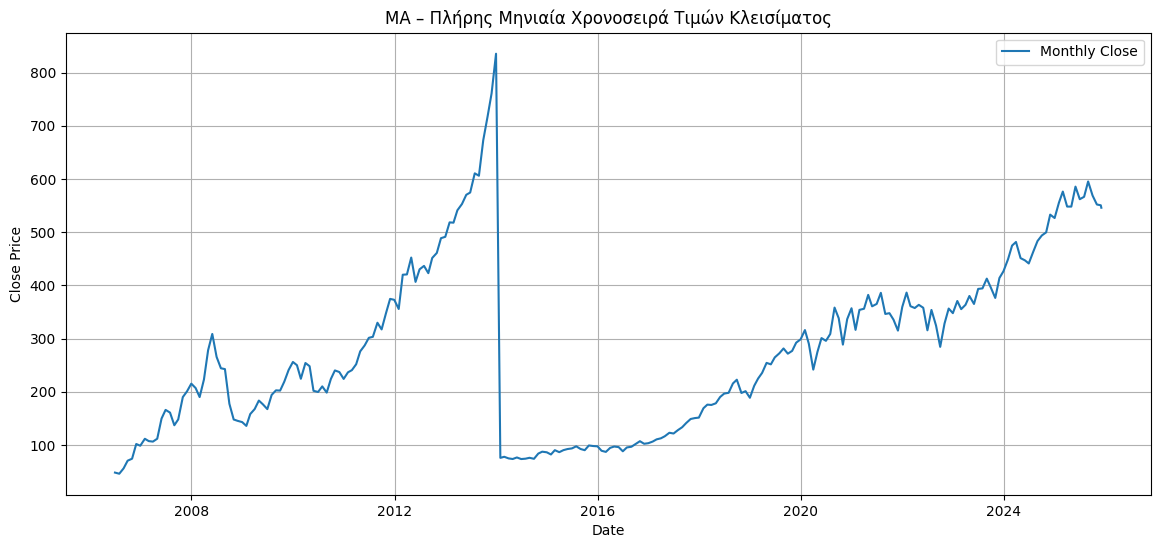

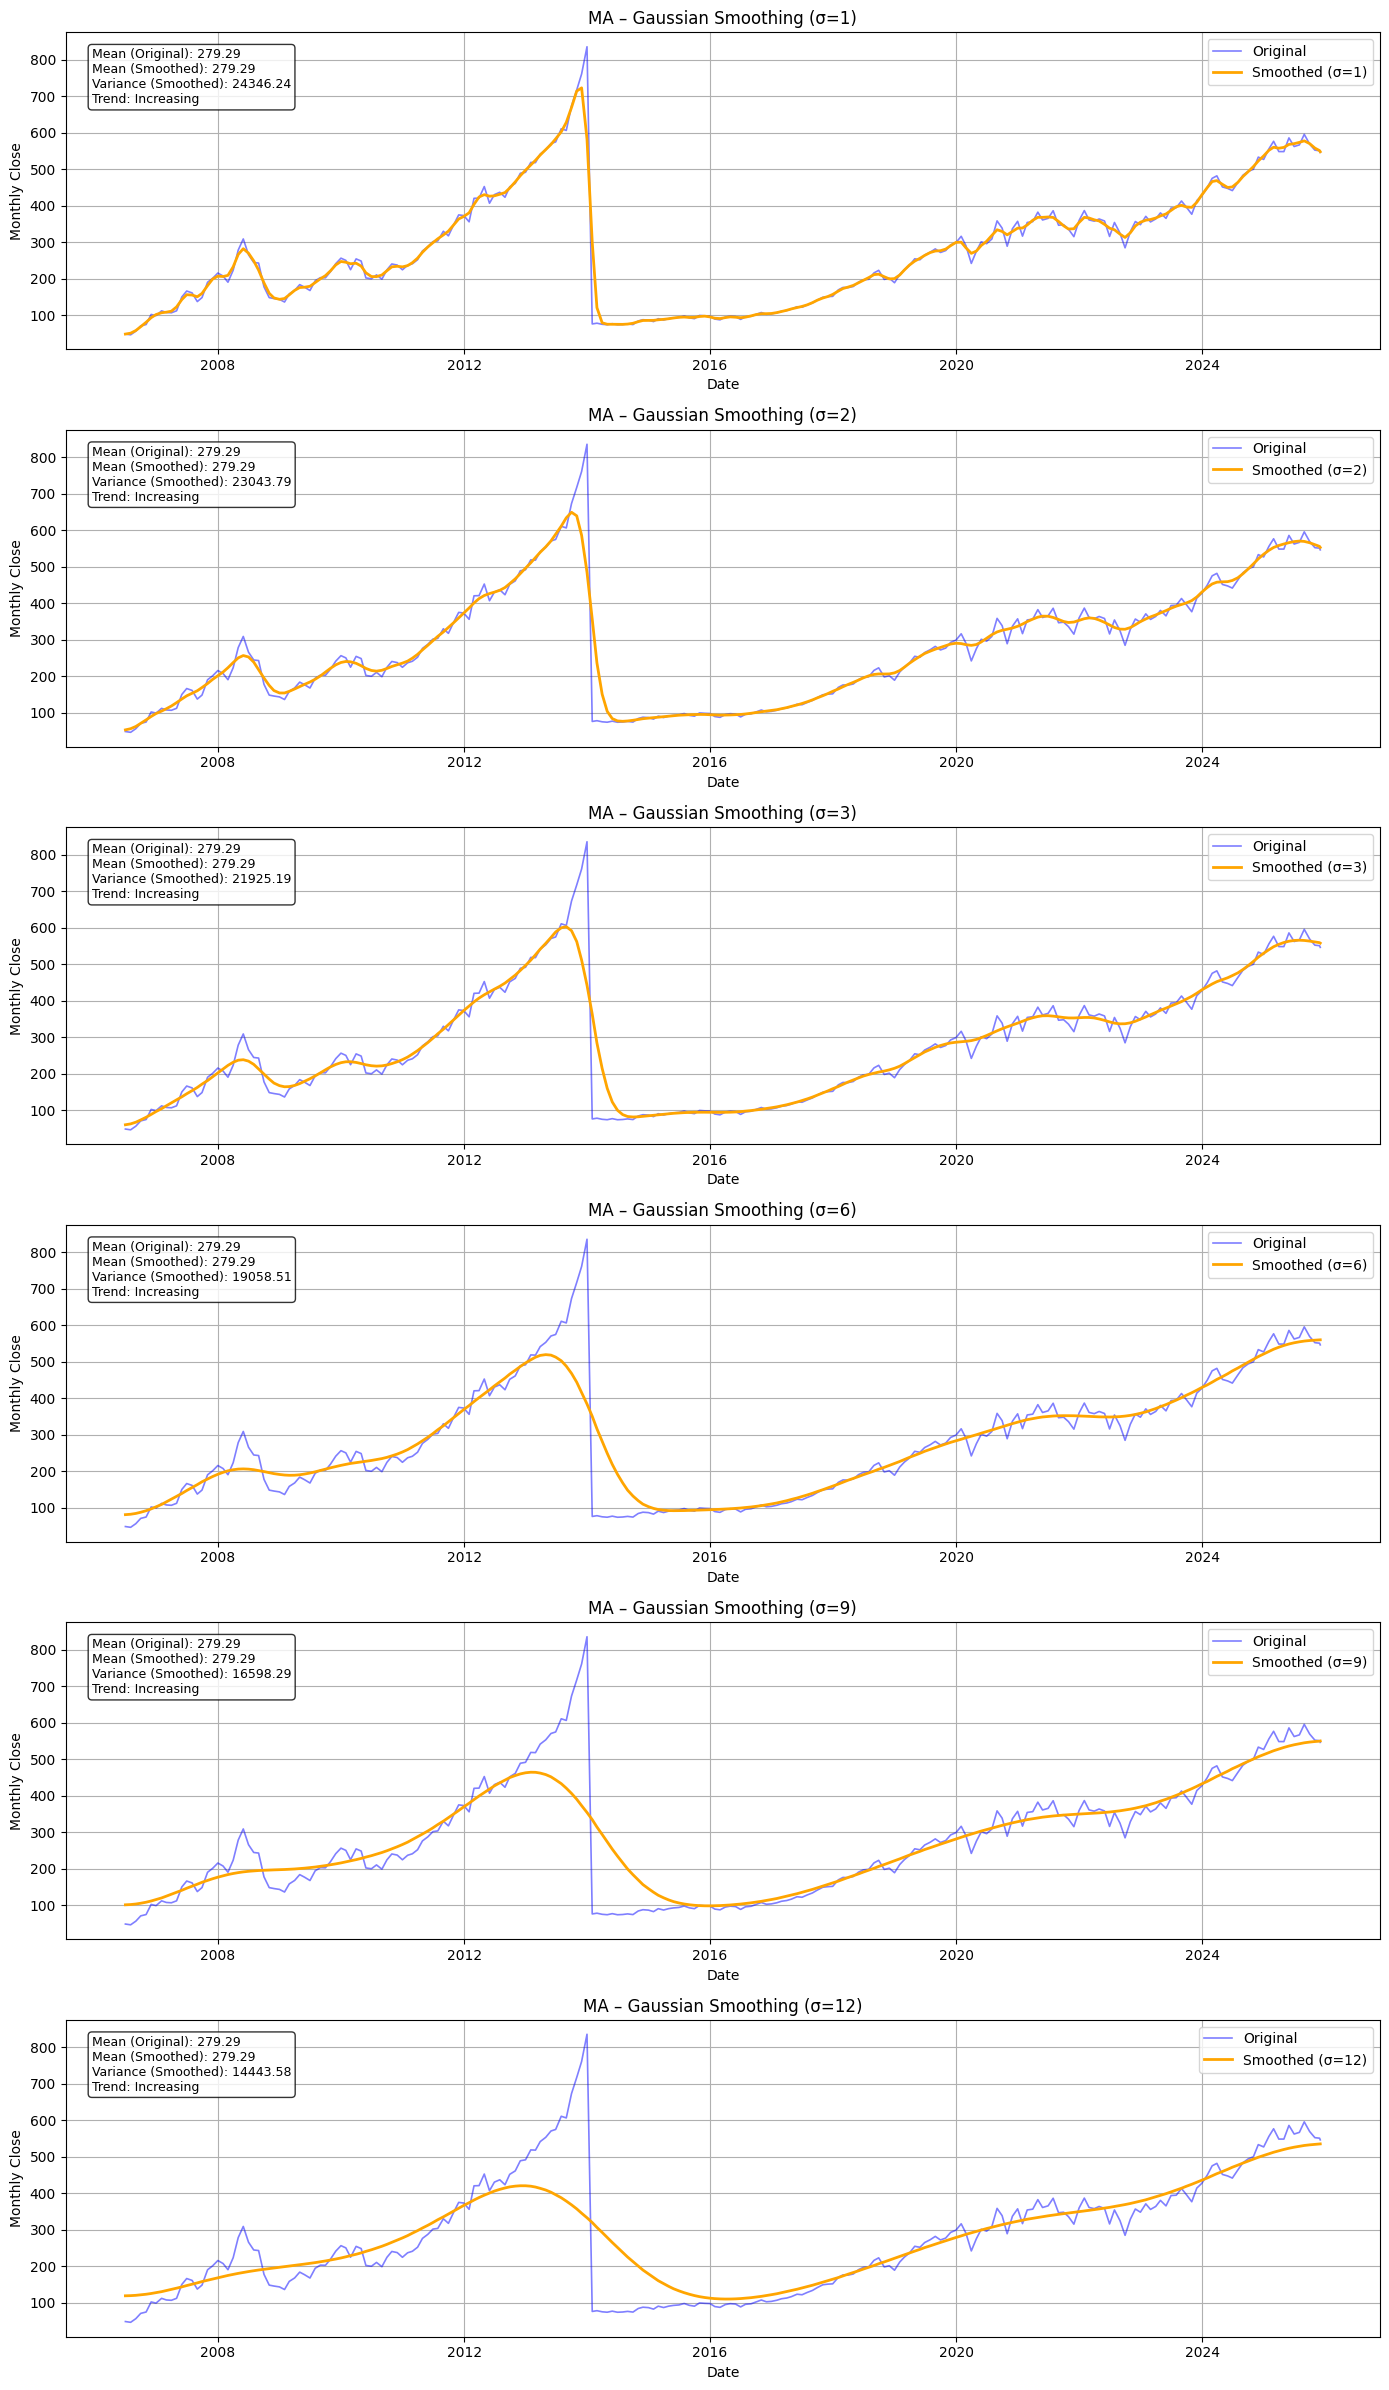

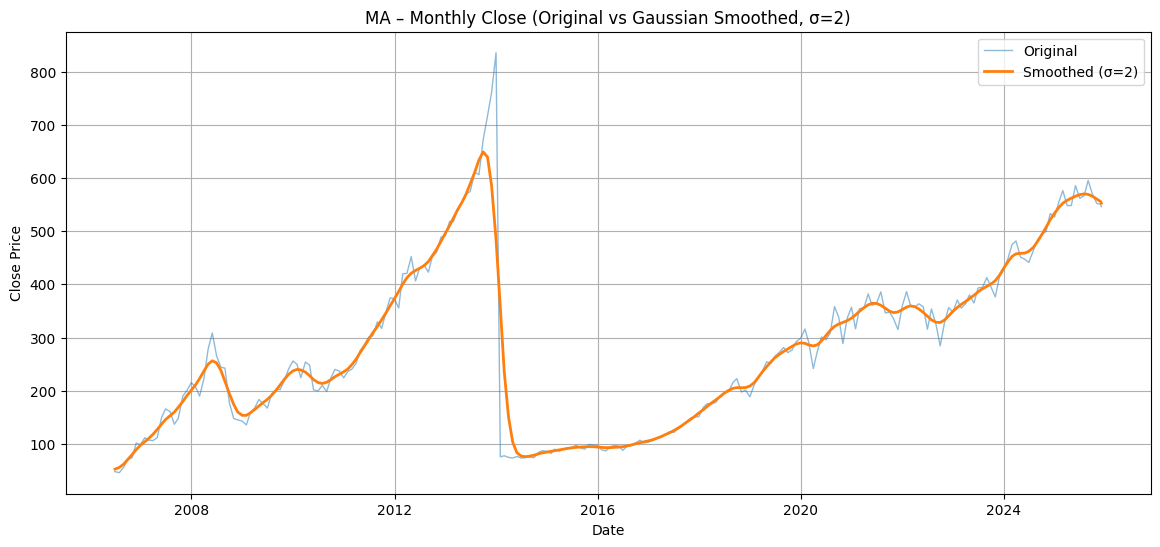

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

# monthly df
df = df_monthly_full.copy()
df = df.sort_values('Date').reset_index(drop=True)

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

print("df.shape:", df.shape)
print("\nΠρώτες γραμμές:")
print(df.head())

print("\nΤελευταίες γραμμές:")
print(df.tail())

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Monthly Close', linewidth=1.5)
plt.title(f'{STOCK_SYMBOL} – Πλήρης Μηνιαία Χρονοσειρά Τιμών Κλεισίματος')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

#  Gaussian smoothing
sigma_values = [1, 2, 3, 6, 9, 12]
fig, axes = plt.subplots(len(sigma_values), 1, figsize=(14, 4 * len(sigma_values)))

for i, sigma in enumerate(sigma_values):
    # Apply Gaussian filter
    smoothed_close = gaussian_filter1d(df['Close'].values.astype(float), sigma=sigma)

    # Statistics
    mean_original = np.mean(df['Close'])
    mean_smoothed = np.mean(smoothed_close)
    variance_smoothed = np.var(smoothed_close)

    # Trend
    slope, intercept, _, _, _ = linregress(range(len(smoothed_close)), smoothed_close)
    trend = "Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Flat"

    # Plot original, smoothed
    axes[i].plot(df['Date'], df['Close'], label='Original', color='blue', linewidth=1.2, alpha=0.5)
    axes[i].plot(df['Date'], smoothed_close, label=f'Smoothed (σ={sigma})', color='orange', linewidth=2)

    stats_text = (
        f"Mean (Original): {mean_original:.2f}\n"
        f"Mean (Smoothed): {mean_smoothed:.2f}\n"
        f"Variance (Smoothed): {variance_smoothed:.2f}\n"
        f"Trend: {trend}"
    )
    axes[i].text(
        0.02, 0.95, stats_text,
        transform=axes[i].transAxes,
        fontsize=9,
        va='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    axes[i].set_title(f'{STOCK_SYMBOL} – Gaussian Smoothing (σ={sigma})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Monthly Close')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

sigma_opt = 2

df['Close_smooth'] = gaussian_filter1d(df['Close'].values.astype(float), sigma=sigma_opt)

# Plot raw vs smoothed
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'],        label='Original', linewidth=1, alpha=0.5)
plt.plot(df['Date'], df['Close_smooth'], label=f'Smoothed (σ={sigma_opt})', linewidth=2)
plt.title(f'{STOCK_SYMBOL} – Monthly Close (Original vs Gaussian Smoothed, σ={sigma_opt})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

**Statistic Analysis**

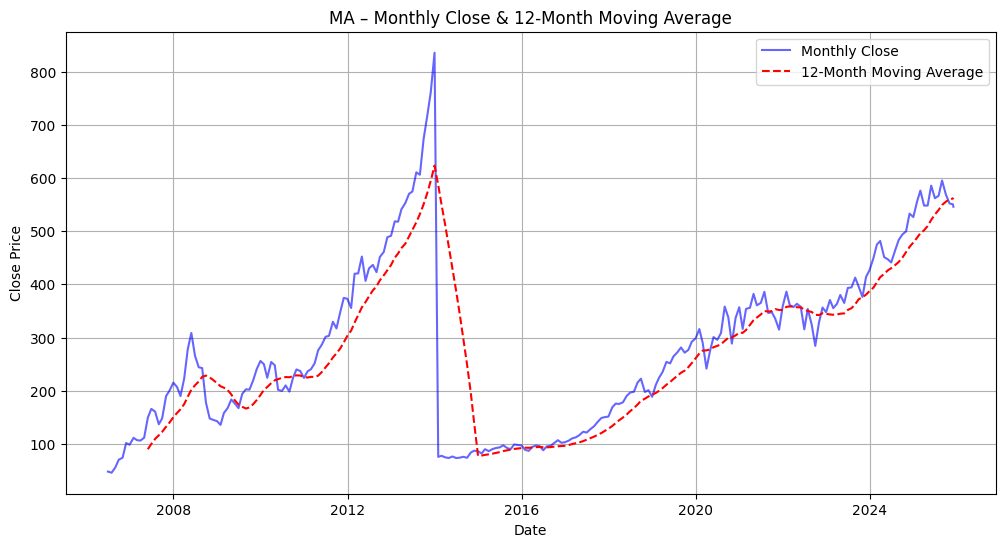

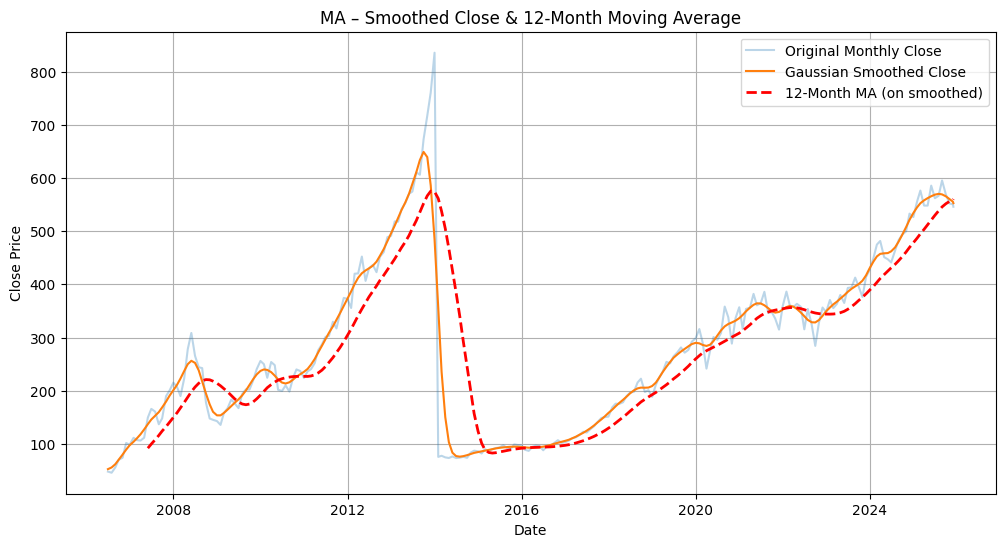

In [19]:
window_months = 12

df['SMA_12'] = df['Close'].rolling(window=window_months).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Monthly Close', color='blue', alpha=0.6)
plt.plot(df['Date'], df['SMA_12'], label='12-Month Moving Average', color='red', linestyle='--')

plt.title(f"{STOCK_SYMBOL} – Monthly Close & 12-Month Moving Average")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

df['SMA_12_smooth'] = df['Close_smooth'].rolling(window=window_months).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'],        label='Original Monthly Close',        alpha=0.3)
plt.plot(df['Date'], df['Close_smooth'], label='Gaussian Smoothed Close',       linewidth=1.5)
plt.plot(df['Date'], df['SMA_12_smooth'], label='12-Month MA (on smoothed)',   color='red', linestyle='--', linewidth=2)

plt.title(f"{STOCK_SYMBOL} – Smoothed Close & 12-Month Moving Average")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

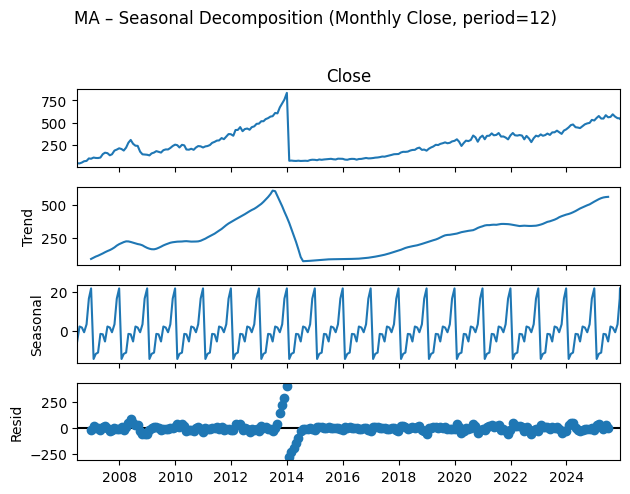

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_season = df.copy().sort_values('Date').reset_index(drop=True)
df_season = df_season.set_index('Date')
df_season = df_season.dropna(subset=['Close'])

# Seasonal Decomposition
decomposition = seasonal_decompose(
    df_season['Close'],
    model='additive',
    period=12
)

plt.figure(figsize=(10, 8))
decomposition.plot()
plt.suptitle(f"{STOCK_SYMBOL} – Seasonal Decomposition (Monthly Close, period=12)", y=1.02)
plt.tight_layout()
plt.show()

**Training, Validation and Testing of Linear Regression Model**

Θα προβλέψουμε τη στήλη: Close
N = 1 → train samples: 72, val samples: 24

Model Parameters for N=1:
Bias: 307.7215277777778
Weight for close_t-1: 66.1413417299311
Weight for volume_t-1: 3.3023728645944694
Model Equation:
Close_t = 307.7215277777778 + (66.1413417299311) * close_t-1 + (3.3023728645944694) * volume_t-1
N = 2 → train samples: 72, val samples: 24

Model Parameters for N=2:
Bias: 307.7215277777778
Weight for close_t-1: 52.27113713746613
Weight for close_t-2: 14.427224649833152
Weight for volume_t-1: 1.1564006923222006
Weight for volume_t-2: 2.0004959774884834
Model Equation:
Close_t = 307.7215277777778 + (52.27113713746613) * close_t-1 + (14.427224649833152) * close_t-2 + (1.1564006923222006) * volume_t-1 + (2.0004959774884834) * volume_t-2
N = 3 → train samples: 72, val samples: 24

Model Parameters for N=3:
Bias: 307.7215277777778
Weight for close_t-1: 42.50379021969372
Weight for close_t-2: -11.432236931503246
Weight for close_t-3: 36.39936468340156
Weight for volume_t-1

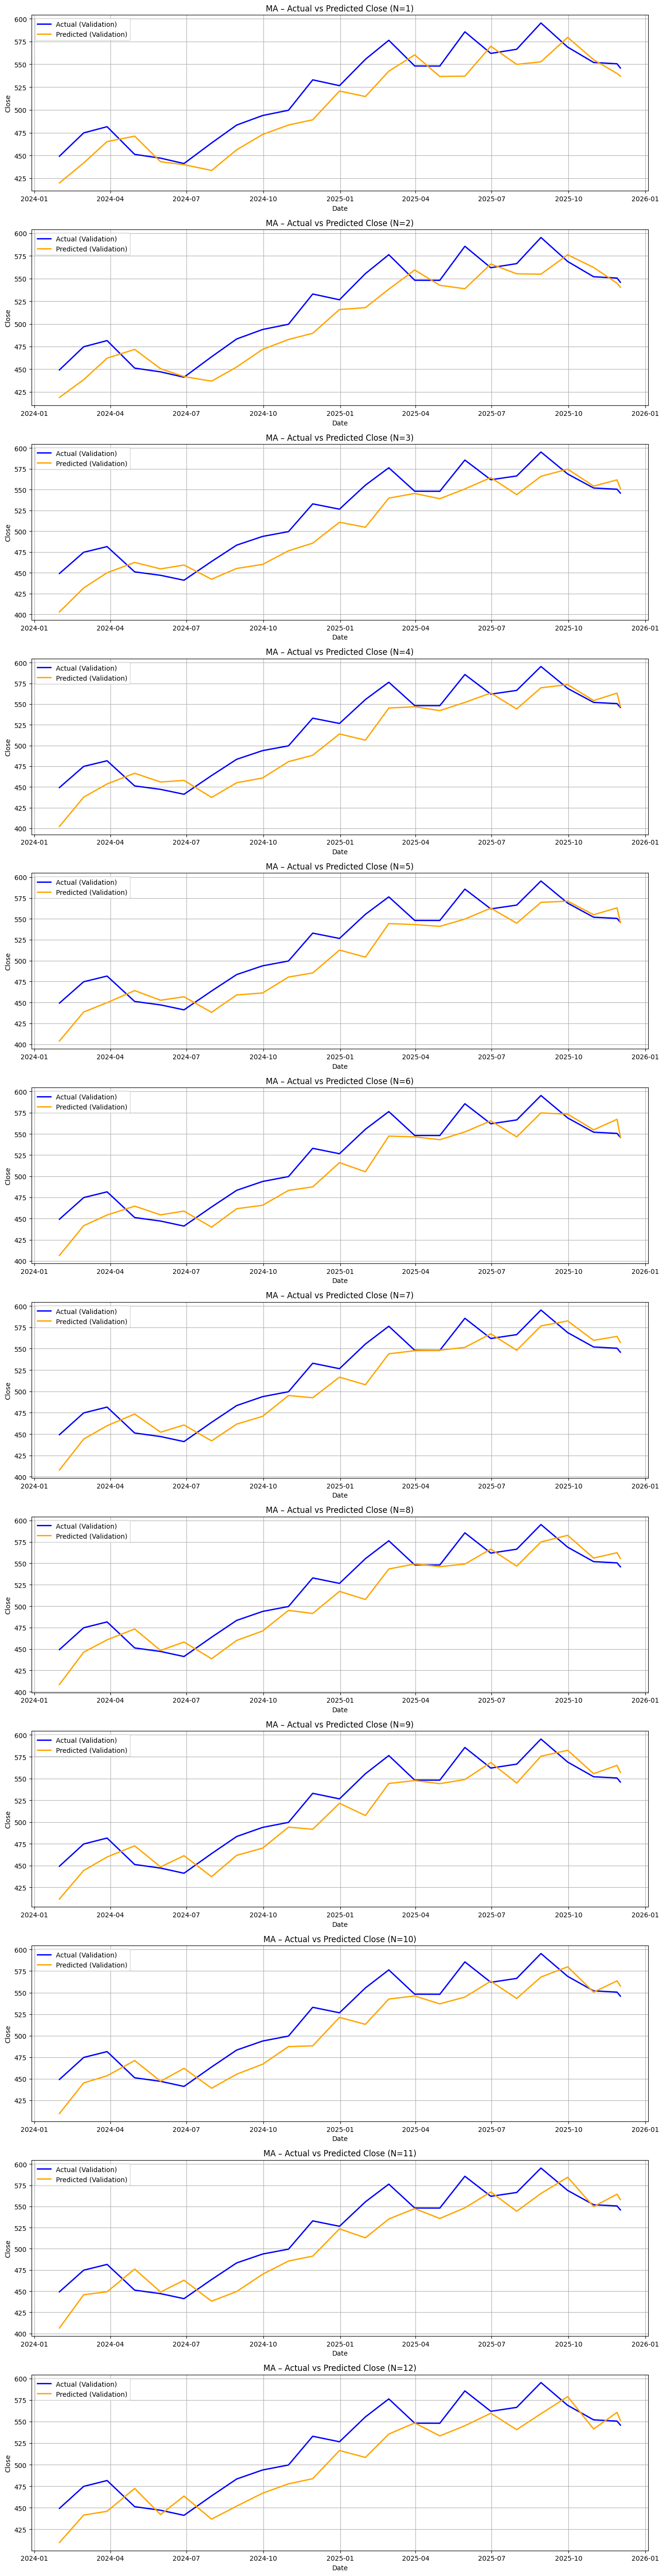


Metrics
     N  Train MAE  Train RMSE   Train MSE    Val MAE   Val RMSE     Val MSE
0    1  17.746597   22.647181  512.894829  20.612422  24.865995  618.317730
1    2  17.454499   22.253986  495.239895  20.229828  24.754907  612.805423
2    3  15.166165   19.962531  398.502655  22.473878  27.088661  733.795560
3    4  15.184301   19.816227  392.682852  21.168010  25.785111  664.871935
4    5  15.013905   19.736277  389.520635  21.167336  26.018897  676.982988
5    6  15.093457   19.465623  378.910487  19.794997  24.271181  589.090223
6    7  14.094525   18.015898  324.572579  19.409006  23.284951  542.188935
7    8  14.171530   17.842490  318.354460  19.234325  23.432844  549.098164
8    9  14.024577   17.750387  315.076238  19.523287  23.564006  555.262400
9   10  13.883635   17.518061  306.882445  20.796008  24.822794  616.171115
10  11  13.885684   17.243583  297.341147  22.062510  25.937485  672.753146
11  12  13.912793   16.964992  287.810951  23.657478  27.724169  768.629551


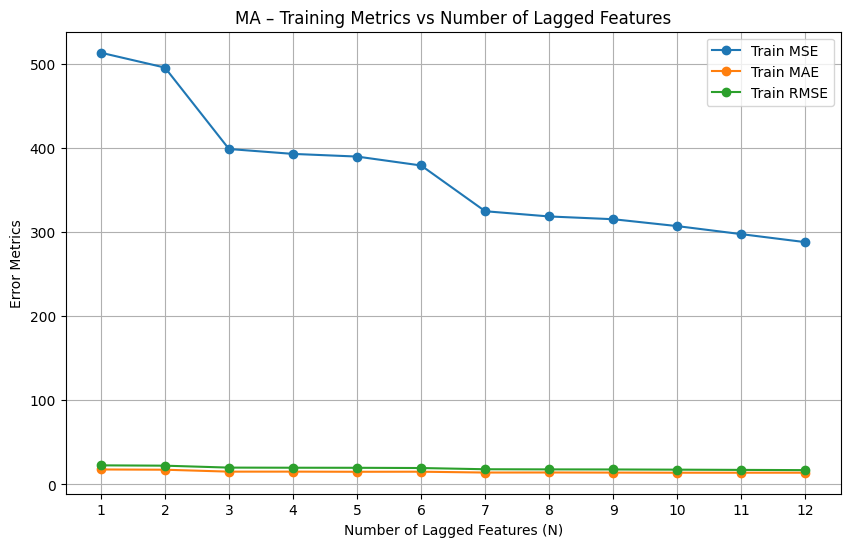

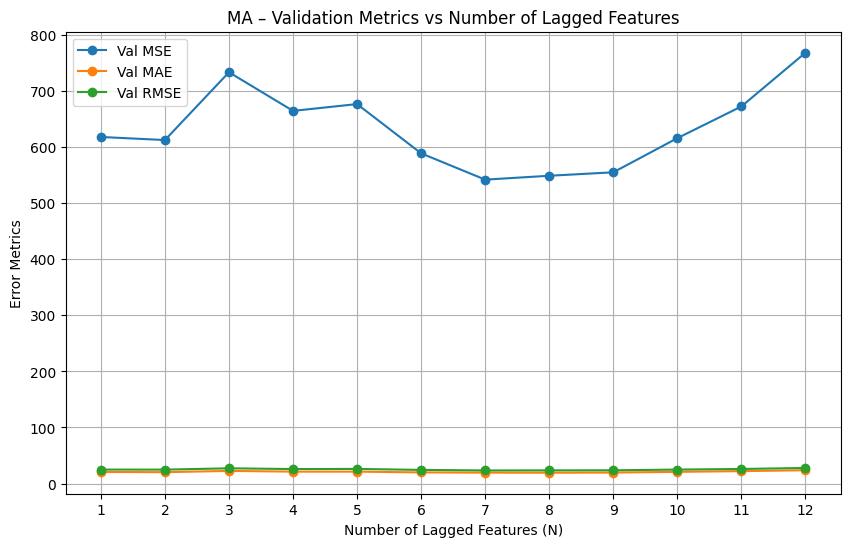

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Monthly Close
TARGET_COL = 'Close'
print("Θα προβλέψουμε τη στήλη:", TARGET_COL)

from sklearn.preprocessing import StandardScaler

def linear_regression_model(N, data, target_col=TARGET_COL):
    data = data.copy().sort_values('Date').reset_index(drop=True)

    for i in range(1, N + 1):
        data[f'close_t-{i}']  = data['Close'].shift(i)
        data[f'volume_t-{i}'] = data['Volume'].shift(i)

    data = data.dropna().reset_index(drop=True)

    train_data = data[(data['Date'] >= '2018-01-01') & (data['Date'] < '2024-01-01')]
    validation_data = data[data['Date'] >= '2024-01-01']

    print(f"N = {N} → train samples: {len(train_data)}, val samples: {len(validation_data)}")

    if len(train_data) == 0 or len(validation_data) == 0:
        raise ValueError(f"Για N={N} δεν υπάρχουν αρκετά train/validation δείγματα.")

    close_feats  = [f'close_t-{i}'  for i in range(1, N + 1)]
    volume_feats = [f'volume_t-{i}' for i in range(1, N + 1)]
    feature_cols = close_feats + volume_feats

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values

    X_val   = validation_data[feature_cols].values
    y_val   = validation_data[target_col].values

    # StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_val_pred   = model.predict(X_val_scaled)

    train_mae  = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mse  = mean_squared_error(y_train, y_train_pred)

    val_mae  = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mse  = mean_squared_error(y_val, y_val_pred)

    weights = model.coef_
    bias    = model.intercept_

    return (train_mae, train_rmse, train_mse,
            val_mae, val_rmse, val_mse,
            y_train, y_train_pred,
            y_val, y_val_pred,
            validation_data['Date'],
            weights, bias,
            model, scaler)


num_tests = 12
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 4.5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    (train_mae, train_rmse, train_mse,
     val_mae, val_rmse, val_mse,
     y_train, y_train_pred,
     y_val, y_val_pred,
     dates, weights, bias, model, scaler) = linear_regression_model(N, df, target_col=TARGET_COL)

    results.append((N, train_mae, train_rmse, train_mse,
                    val_mae, val_rmse, val_mse))

    ax = axes[idx]

    # Plot actual vs predicted (validation)
    ax.plot(dates, y_val,      label='Actual (Validation)',    color='blue',   linewidth=2)
    ax.plot(dates, y_val_pred, label='Predicted (Validation)', color='orange', linewidth=2)
    ax.set_title(f'{STOCK_SYMBOL} – Actual vs Predicted {TARGET_COL} (N={N})')
    ax.set_xlabel('Date')
    ax.set_ylabel(TARGET_COL)
    ax.legend()
    ax.grid(True)

    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias}")
    equation = f"{TARGET_COL}_t = {bias}"

    for i, coef in enumerate(weights[:N]):
        equation += f" + ({coef}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef}")
    for i, coef in enumerate(weights[N:]):
        equation += f" + ({coef}) * volume_t-{i+1}"
        print(f"Weight for volume_t-{i+1}: {coef}")
    print("Model Equation:")
    print(equation)

plt.tight_layout()
plt.show()

# metrics
results_df = pd.DataFrame(results, columns=[
    'N',
    'Train MAE', 'Train RMSE', 'Train MSE',
    'Val MAE',   'Val RMSE',   'Val MSE'
])

print("\nMetrics")
print(results_df)

# Training Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
plt.plot(results_df['N'], results_df['Train MSE'],  marker='o', linestyle='-', label='Train MSE')
plt.plot(results_df['N'], results_df['Train MAE'],  marker='o', linestyle='-', label='Train MAE')
plt.plot(results_df['N'], results_df['Train RMSE'], marker='o', linestyle='-', label='Train RMSE')

plt.title(f'{STOCK_SYMBOL} – Training Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(results_df['N'])
plt.legend()
plt.grid(True)
plt.show()

# Validation Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
plt.plot(results_df['N'], results_df['Val MSE'],  marker='o', linestyle='-', label='Val MSE')
plt.plot(results_df['N'], results_df['Val MAE'],  marker='o', linestyle='-', label='Val MAE')
plt.plot(results_df['N'], results_df['Val RMSE'], marker='o', linestyle='-', label='Val RMSE')

plt.title(f'{STOCK_SYMBOL} – Validation Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(results_df['N'])
plt.legend()
plt.grid(True)
plt.show()

**Actual vs predicted & metrics για N = 1..6**

In [22]:
import numpy as np
from pandas.tseries.offsets import MonthEnd
import pandas as pd

def predict_next_month_close(df, model, scaler, N):
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    if len(df_sorted) < N:
        raise ValueError(f"Χρειάζονται τουλάχιστον {N} μήνες δεδομένων για πρόβλεψη.")

    closes = df_sorted['Close'].values
    vols   = df_sorted['Volume'].values

    close_lags   = closes[-N:][::-1]
    volume_lags  = vols[-N:][::-1]

    x = np.concatenate([close_lags, volume_lags]).reshape(1, -1)

    x_scaled = scaler.transform(x)

    predicted_close = model.predict(x_scaled)[0]

    last_date = df_sorted['Date'].max()
    last_eom = last_date + MonthEnd(0)
    next_month_date = (last_eom + MonthEnd(1)).date()

    return next_month_date, predicted_close

N_best = 7

#Train for N_best
(train_mae, train_rmse, train_mse,
 val_mae, val_rmse, val_mse,
 y_train, y_train_pred,
 y_val, y_val_pred,
 dates, weights, bias,
 model, scaler) = linear_regression_model(N_best, df, target_col='Close')

print(f"\nLinear model για N={N_best}: Val RMSE = {val_rmse:.2f}")

print(f"\nLinear model για N={N_best}: Val RMSE = {val_rmse:.2f}")

target_year = 2025
target_month = 12

# cutoff month
cutoff = pd.Timestamp(target_year, target_month, 1) - MonthEnd(1)

df_until_cutoff = df[df['Date'] <= cutoff].copy()

print("Τελευταία ημερομηνία στο df_until_cutoff:", df_until_cutoff['Date'].max())

next_date, next_pred = predict_next_month_close(df_until_cutoff, model, scaler, N_best)
print(f"Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις {next_date}: {next_pred:.2f} $")


N = 7 → train samples: 72, val samples: 24

Linear model για N=7: Val RMSE = 23.28

Linear model για N=7: Val RMSE = 23.28
Τελευταία ημερομηνία στο df_until_cutoff: 2025-11-28 00:00:00
Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις 2025-12-31: 557.23 $


In [23]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np

target_year = 2025
target_month = 1

# cutoff =
cutoff = pd.Timestamp(target_year, target_month, 1) - MonthEnd(1)
print("cutoff:", cutoff)

df_until_cutoff = df[df['Date'] <= cutoff].copy()
print("Τελευταία ημερομηνία στο df_until_cutoff:", df_until_cutoff['Date'].max())

pred_date, pred_close = predict_next_month_close(df_until_cutoff, model, scaler, N_best)
print(f"Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις {pred_date}: {pred_close:.2f} $")

# actual close value
mask_jan = (df['Date'].dt.year == target_year) & (df['Date'].dt.month == target_month)
actual_close = df.loc[mask_jan, 'Close'].iloc[0]

print(f"Πραγματική τιμή κλεισίματος για Ιανουάριο {target_year}: {actual_close:.2f} $")

# Errors
abs_err  = abs(actual_close - pred_close)
perc_err = abs_err / actual_close * 100

print(f"Απόλυτο σφάλμα: {abs_err:.2f} $")
print(f"Ποσοστιαίο σφάλμα: {perc_err:.2f}%")


cutoff: 2024-12-31 00:00:00
Τελευταία ημερομηνία στο df_until_cutoff: 2024-12-31 00:00:00
Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις 2025-01-31: 507.75 $
Πραγματική τιμή κλεισίματος για Ιανουάριο 2025: 555.43 $
Απόλυτο σφάλμα: 47.68 $
Ποσοστιαίο σφάλμα: 8.58%



Metrics για Polynomial Degree 1:
   N  Train MAE  Train RMSE    Train MSE    Val MAE   Val RMSE      Val MSE  \
0  1  23.175515   56.720477  3217.212467  28.743822  33.726771  1137.495113   
1  2  23.129353   56.658768  3210.216046  28.355182  33.392020  1115.026975   
2  3  23.174998   56.602926  3203.891265  28.563181  33.476496  1120.675795   
3  4  23.117198   56.580065  3201.303765  28.225056  33.106201  1096.020555   
4  5  23.274595   56.467274  3188.553084  27.674726  32.620490  1064.096372   
5  6  23.124113   56.422935  3183.547637  28.034320  32.946922  1085.499699   

    alpha  
0   0.001  
1   0.001  
2  10.000  
3  10.000  
4  10.000  
5  10.000  


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+05, tolerance: 3.871e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e+04, tolerance: 1.709e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e+04, tolerance: 2.675e


Metrics για Polynomial Degree 2:
   N  Train MAE  Train RMSE    Train MSE    Val MAE   Val RMSE      Val MSE  \
0  1  24.587202   48.393434  2341.924486  72.280680  82.474807  6802.093826   
1  2  22.519358   43.842489  1922.163847  39.456491  46.333932  2146.833252   
2  3  21.237668   42.838623  1835.147579  37.831710  42.720800  1825.066777   
3  4  20.270333   40.686385  1655.381924  38.482620  43.743145  1913.462748   
4  5  19.860285   30.658875   939.966589  39.209921  52.198437  2724.676792   
5  6  17.190478   26.575934   706.280251  46.492506  59.164644  3500.455095   

    alpha  
0   0.001  
1  10.000  
2  10.000  
3  10.000  
4  10.000  
5  10.000  


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.039e+04, tolerance: 1.709e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.797e+04, tolerance: 2.675e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+05, tolerance: 3.899e


Metrics για Polynomial Degree 3:
   N  Train MAE  Train RMSE    Train MSE     Val MAE    Val RMSE  \
0  1  22.663678   34.286984  1175.597264  133.008607  160.739364   
1  2  19.007485   25.821817   666.766242   65.295849   81.147178   
2  3  16.003105   21.018333   441.770327   93.248824  117.447062   
3  4  11.376585   15.724587   247.262634   73.103173   92.233796   
4  5   5.840117    8.364675    69.967787   67.979342   84.231239   
5  6   3.565625    5.510220    30.362527   80.968333  110.119630   

        Val MSE   alpha  
0  25837.142986   1.000  
1   6584.864538   0.001  
2  13793.812406   0.001  
3   8507.073148  10.000  
4   7094.901648   0.001  
5  12126.332853   1.000  


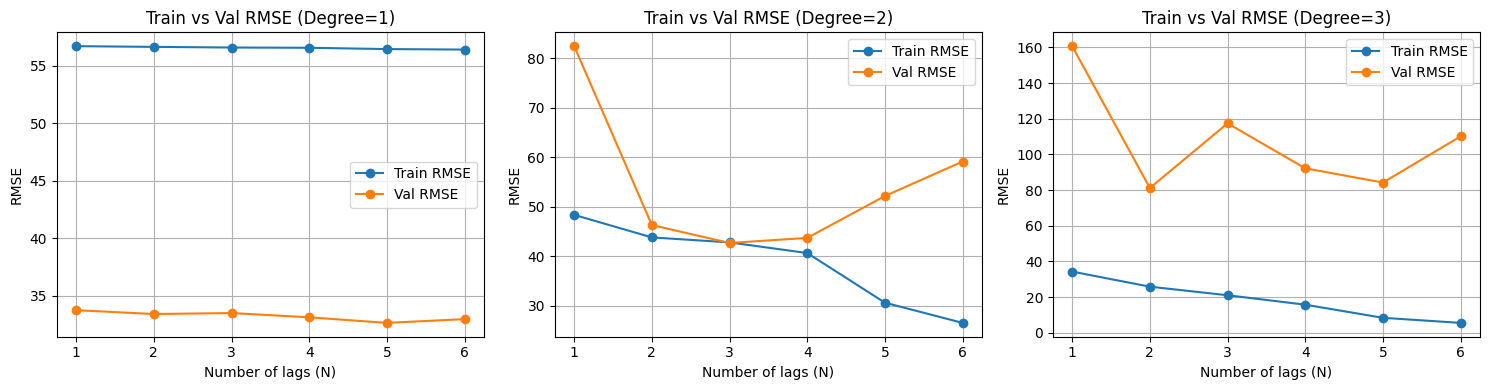

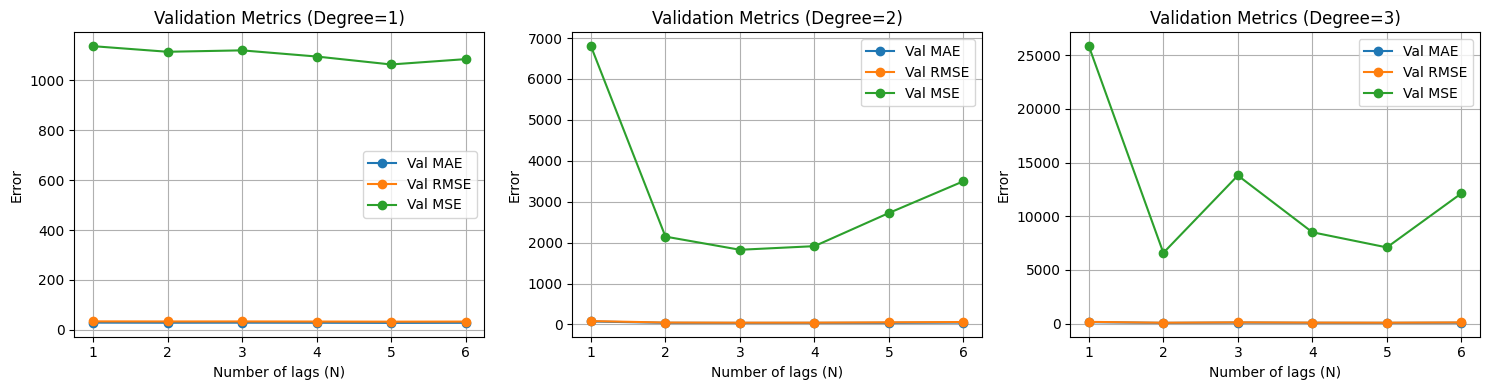

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def polynomial_regression_model_L1(degree, N, data, target_col='Close'):
    """
    Πολυωνυμική παλινδρόμηση με L1 (Lasso) πάνω σε lags της Close ΚΑΙ του Volume.

    degree : βαθμός πολυωνυμικού (1,2,3,...)
    N      : αριθμός lags (close_t-1..close_t-N, volume_t-1..volume_t-N)
    data   : DataFrame με στήλες Date, Close, Volume
    """

    d = data.copy().sort_values('Date').reset_index(drop=True)

    # N lagged features for Close & Volume
    for i in range(1, N + 1):
        d[f'close_t-{i}']  = d['Close'].shift(i)
        d[f'volume_t-{i}'] = d['Volume'].shift(i)

    d = d.dropna().reset_index(drop=True)

    train_data = d[d['Date'] < '2024-01-01']
    val_data   = d[d['Date'] >= '2024-01-01']

    if len(train_data) == 0 or len(val_data) == 0:
        raise ValueError(f"degree={degree}, N={N}: δεν υπάρχουν αρκετά train/val δείγματα.")

    # Features
    close_feats  = [f'close_t-{i}'  for i in range(1, N + 1)]
    volume_feats = [f'volume_t-{i}' for i in range(1, N + 1)]
    feature_cols = close_feats + volume_feats

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_val   = val_data[feature_cols].values
    y_val   = val_data[target_col].values

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly   = poly.transform(X_val)

    # GridSearchCV
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    base_lasso = Lasso(max_iter=10000)

    grid_search = GridSearchCV(
        base_lasso,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train_poly, y_train)
    alpha = grid_search.best_params_['alpha']

    # Final Lasso
    model = Lasso(alpha=alpha, max_iter=100000)
    model.fit(X_train_poly, y_train)

    # predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred   = model.predict(X_val_poly)

    train_mse  = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae  = mean_absolute_error(y_train, y_train_pred)

    val_mse  = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae  = mean_absolute_error(y_val, y_val_pred)

    weights = model.coef_
    bias    = model.intercept_

    return (train_mae, train_rmse, train_mse,
            val_mae, val_rmse, val_mse,
            y_train, y_train_pred,
            y_val, y_val_pred,
            val_data['Date'],
            weights, bias,
            alpha)

num_tests  = 6   # N = 1..6
max_degree = 3   # degree = 1..3

all_results = []

fig_train, axs_train = plt.subplots(1, max_degree, figsize=(5 * max_degree, 4))
fig_val,   axs_val   = plt.subplots(1, max_degree, figsize=(5 * max_degree, 4))

if max_degree == 1:
    axs_train = [axs_train]
    axs_val   = [axs_val]

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        (train_mae, train_rmse, train_mse,
         val_mae, val_rmse, val_mse,
         y_train, y_train_pred,
         y_val, y_val_pred,
         dates, weights, bias,
         alpha) = polynomial_regression_model_L1(degree, N, df, target_col='Close')

        results.append((N, train_mae, train_rmse, train_mse,
                        val_mae, val_rmse, val_mse, alpha))

    results_df = pd.DataFrame(results, columns=[
        'N',
        'Train MAE', 'Train RMSE', 'Train MSE',
        'Val MAE',   'Val RMSE',   'Val MSE',
        'alpha'
    ])

    all_results.append((degree, results_df))

    print(f"\nMetrics για Polynomial Degree {degree}:")
    print(results_df)

    ax_tr = axs_train[degree - 1]
    ax_tr.plot(results_df['N'], results_df['Train RMSE'], marker='o', linestyle='-', label='Train RMSE')
    ax_tr.plot(results_df['N'], results_df['Val RMSE'],   marker='o', linestyle='-', label='Val RMSE')
    ax_tr.set_title(f'Train vs Val RMSE (Degree={degree})')
    ax_tr.set_xlabel('Number of lags (N)')
    ax_tr.set_ylabel('RMSE')
    ax_tr.legend()
    ax_tr.grid(True)

    ax_v = axs_val[degree - 1]
    ax_v.plot(results_df['N'], results_df['Val MAE'],  marker='o', linestyle='-', label='Val MAE')
    ax_v.plot(results_df['N'], results_df['Val RMSE'], marker='o', linestyle='-', label='Val RMSE')
    ax_v.plot(results_df['N'], results_df['Val MSE'],  marker='o', linestyle='-', label='Val MSE')
    ax_v.set_title(f'Validation Metrics (Degree={degree})')
    ax_v.set_xlabel('Number of lags (N)')
    ax_v.set_ylabel('Error')
    ax_v.legend()
    ax_v.grid(True)

fig_train.tight_layout()
fig_val.tight_layout()
plt.show()

**Using L1-Normalization**

In [25]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def polynomial_regression_model_L1(degree, N, data, target_col='Close'):
    """
    Πολυωνυμική παλινδρόμηση με L1 (Lasso) πάνω σε lags της Close ΚΑΙ του Volume,
    με StandardScaler στα lags.
    """

    base = data[['Date', 'Close', 'Volume']].copy()
    base = base.sort_values('Date').reset_index(drop=True)

    for i in range(1, N + 1):
        base[f'close_t-{i}']  = base['Close'].shift(i)
        base[f'volume_t-{i}'] = base['Volume'].shift(i)

    base = base.dropna().reset_index(drop=True)

    train_data = base[(base['Date'] >= '2018-01-01') & (base['Date'] < '2024-01-01')]
    val_data   = base[base['Date'] >= '2024-01-01']

    if len(train_data) == 0 or len(val_data) == 0:
        raise ValueError(f"degree={degree}, N={N}: δεν υπάρχουν αρκετά train/val δείγματα.")

    # Features (lags Close & Volume)
    close_feats  = [f'close_t-{i}'  for i in range(1, N + 1)]
    volume_feats = [f'volume_t-{i}' for i in range(1, N + 1)]
    feature_cols = close_feats + volume_feats

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_val   = val_data[feature_cols].values
    y_val   = val_data[target_col].values

    # StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    # Polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly   = poly.transform(X_val_scaled)

    # GridSearchCV
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    base_lasso = Lasso(max_iter=10000)

    grid_search = GridSearchCV(
        base_lasso,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train_poly, y_train)
    alpha = grid_search.best_params_['alpha']

    model = Lasso(alpha=alpha, max_iter=100000)
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_val_pred   = model.predict(X_val_poly)

    train_mse  = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae  = mean_absolute_error(y_train, y_train_pred)

    val_mse  = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae  = mean_absolute_error(y_val, y_val_pred)

    weights = model.coef_
    bias    = model.intercept_

    return (train_mae, train_rmse, train_mse,
            val_mae, val_rmse, val_mse,
            y_train, y_train_pred,
            y_val, y_val_pred,
            val_data['Date'],
            weights, bias,
            alpha, model, scaler, poly)

In [26]:
from pandas.tseries.offsets import MonthEnd

def predict_next_month_close_poly(df, model, scaler, poly, N):
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    if len(df_sorted) < N:
        raise ValueError(f"Χρειάζονται τουλάχιστον {N} μήνες δεδομένων για πρόβλεψη.")

    closes = df_sorted['Close'].values
    vols   = df_sorted['Volume'].values

    close_lags   = closes[-N:][::-1]
    volume_lags  = vols[-N:][::-1]

    x_raw = np.concatenate([close_lags, volume_lags]).reshape(1, -1)

    x_scaled = scaler.transform(x_raw)
    x_poly   = poly.transform(x_scaled)

    predicted_close = model.predict(x_poly)[0]

    last_date = df_sorted['Date'].max()
    last_eom  = last_date + MonthEnd(0)
    next_month_date = (last_eom + MonthEnd(1)).date()

    return next_month_date, predicted_close


In [27]:
degree_best = 1
N_best      = 5

(train_mae, train_rmse, train_mse,
 val_mae, val_rmse, val_mse,
 y_train, y_train_pred,
 y_val, y_val_pred,
 dates, weights, bias,
 alpha, model, scaler, poly) = polynomial_regression_model_L1(degree_best, N_best, df, target_col='Close')

print(f"Degree={degree_best}, N={N_best}, alpha={alpha}")
print(f"Train RMSE={train_rmse:.2f}, Val RMSE={val_rmse:.2f}")

target_year  = 2025
target_month = 12

cutoff = pd.Timestamp(target_year, target_month, 1) - MonthEnd(1)
df_until_cutoff = df[df['Date'] <= cutoff].copy()

print("Τελευταία ημερομηνία στο df_until_cutoff:", df_until_cutoff['Date'].max())

next_date, next_pred = predict_next_month_close_poly(df_until_cutoff, model, scaler, poly, N_best)
print(f"Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις {next_date}: {next_pred:.2f} $")


Degree=1, N=5, alpha=1
Train RMSE=20.27, Val RMSE=27.37
Τελευταία ημερομηνία στο df_until_cutoff: 2025-11-28 00:00:00
Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις 2025-12-31: 546.61 $


In [28]:
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def evaluate_month_prediction(target_year, target_month, df, model, scaler, N):
    """
    Κάνει πρόβλεψη για τον μήνα (target_year, target_month)
    και τη συγκρίνει με την πραγματική τιμή Close του μήνα αυτού.
    """

    # cutoff
    cutoff = pd.Timestamp(target_year, target_month, 1) - MonthEnd(1)
    print("cutoff:", cutoff)

    df_until_cutoff = df[df['Date'] <= cutoff].copy()
    print("Τελευταία ημερομηνία στο df_until_cutoff:", df_until_cutoff['Date'].max())

    pred_date, pred_close = predict_next_month_close(df_until_cutoff, model, scaler, N)
    print(f"\nΠροβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις {pred_date}: {pred_close:.2f} $")

    mask = (df['Date'].dt.year == target_year) & (df['Date'].dt.month == target_month)
    if not mask.any():
        print(f"⚠ Δεν βρέθηκαν πραγματικά δεδομένα για {target_month:02d}/{target_year}.")
        return

    actual_close = df.loc[mask, 'Close'].iloc[0]
    print(f"Πραγματική τιμή κλεισίματος για {target_month:02d}/{target_year}: {actual_close:.2f} $")

    abs_err  = abs(actual_close - pred_close)
    perc_err = abs_err / actual_close * 100

    print(f"Απόλυτο σφάλμα: {abs_err:.2f} $")
    print(f"Ποσοστιαίο σφάλμα: {perc_err:.2f}%")

    return pred_close, actual_close, abs_err, perc_err

In [29]:
pred_close_jan, actual_close_jan, abs_err_jan, perc_err_jan = evaluate_month_prediction(
    target_year=2025,
    target_month=1,
    df=df,
    model=model,
    scaler=scaler,
    N=N_best
)

cutoff: 2024-12-31 00:00:00
Τελευταία ημερομηνία στο df_until_cutoff: 2024-12-31 00:00:00

Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις 2025-01-31: 507.21 $
Πραγματική τιμή κλεισίματος για 01/2025: 555.43 $
Απόλυτο σφάλμα: 48.22 $
Ποσοστιαίο σφάλμα: 8.68%


**Using L2-Normalization**


[L2 Ridge] Metrics για Polynomial Degree 1:
   N  Train MAE  Train RMSE   Train MSE    Val MAE   Val RMSE     Val MSE  \
0  1  17.746585   22.647181  512.894830  20.613773  24.867667  618.400841   
1  2  17.454351   22.253986  495.239899  20.230685  24.756239  612.871350   
2  3  15.166741   19.962555  398.503610  22.476101  27.093748  734.071202   
3  4  15.184274   19.816228  392.682874  21.170005  25.787294  664.984507   
4  5  15.014133   19.736278  389.520664  21.169207  26.021202  677.102928   
5  6  15.093542   19.465624  378.910517  19.796989  24.273109  589.183833   

   alpha  
0  0.001  
1  0.001  
2  0.010  
3  0.001  
4  0.001  
5  0.001  

[L2 Ridge] Metrics για Polynomial Degree 2:
   N  Train MAE  Train RMSE   Train MSE    Val MAE   Val RMSE      Val MSE  \
0  1  17.246771   22.322329  498.286367  52.394258  57.235182  3275.866084   
1  2  16.089577   21.661896  469.237753  46.090197  50.877476  2588.517588   
2  3  13.664725   17.800563  316.860058  56.868802  61.8222

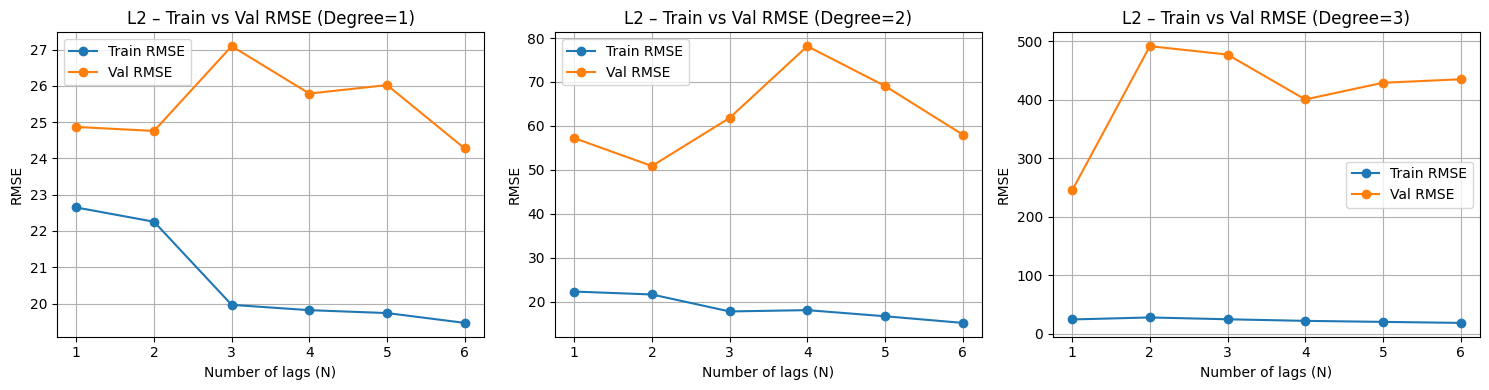

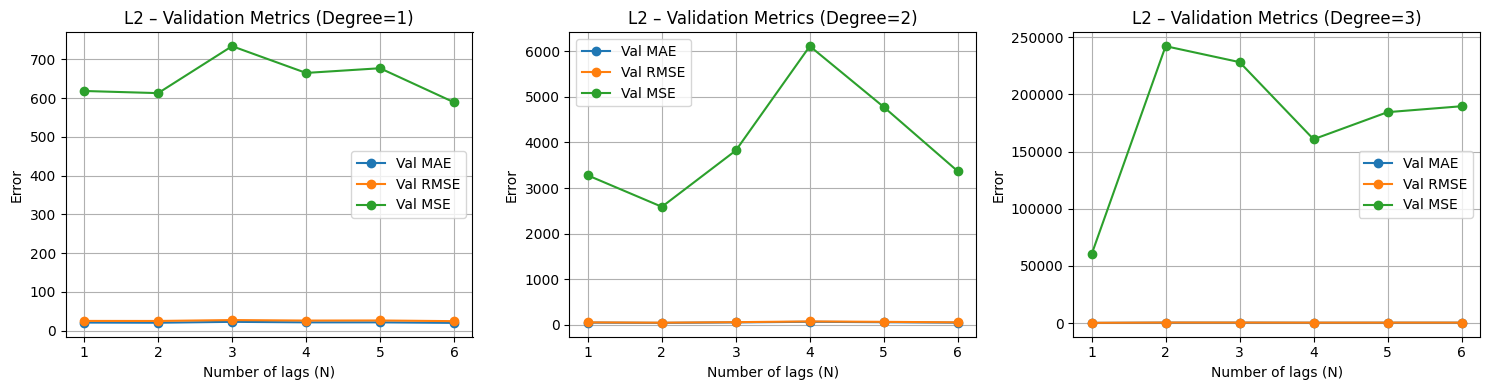

In [30]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def polynomial_regression_model_L2(degree, N, data, target_col='Close'):
    """
    Πολυωνυμική παλινδρόμηση με L2 (Ridge) πάνω σε lags της Close ΚΑΙ του Volume,
    με StandardScaler στα lags.
    """

    base = data[['Date', 'Close', 'Volume']].copy()
    base = base.sort_values('Date').reset_index(drop=True)

    for i in range(1, N + 1):
        base[f'close_t-{i}']  = base['Close'].shift(i)
        base[f'volume_t-{i}'] = base['Volume'].shift(i)

    base = base.dropna().reset_index(drop=True)

    train_data = base[(base['Date'] >= '2018-01-01') & (base['Date'] < '2024-01-01')]
    val_data   = base[base['Date'] >= '2024-01-01']

    if len(train_data) == 0 or len(val_data) == 0:
        raise ValueError(f"degree={degree}, N={N}: δεν υπάρχουν αρκετά train/val δείγματα.")

    close_feats  = [f'close_t-{i}'  for i in range(1, N + 1)]
    volume_feats = [f'volume_t-{i}' for i in range(1, N + 1)]
    feature_cols = close_feats + volume_feats

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_val   = val_data[feature_cols].values
    y_val   = val_data[target_col].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly   = poly.transform(X_val_scaled)

    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    base_ridge = Ridge(max_iter=10000)

    grid_search = GridSearchCV(
        base_ridge,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train_poly, y_train)
    alpha = grid_search.best_params_['alpha']

    model = Ridge(alpha=alpha, max_iter=100000)
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_val_pred   = model.predict(X_val_poly)

    train_mse  = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae  = mean_absolute_error(y_train, y_train_pred)

    val_mse  = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae  = mean_absolute_error(y_val, y_val_pred)

    weights = model.coef_
    bias    = model.intercept_

    return (train_mae, train_rmse, train_mse,
            val_mae, val_rmse, val_mse,
            y_train, y_train_pred,
            y_val, y_val_pred,
            val_data['Date'],
            weights, bias,
            alpha, model, scaler, poly)

import matplotlib.pyplot as plt

num_tests  = 6   # N = 1..6
max_degree = 3   # degree = 1..3

all_results_L2 = []

fig_train, axs_train = plt.subplots(1, max_degree, figsize=(5 * max_degree, 4))
fig_val,   axs_val   = plt.subplots(1, max_degree, figsize=(5 * max_degree, 4))

if max_degree == 1:
    axs_train = [axs_train]
    axs_val   = [axs_val]

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        (train_mae, train_rmse, train_mse,
         val_mae, val_rmse, val_mse,
         y_train, y_train_pred,
         y_val, y_val_pred,
         dates, weights, bias,
         alpha, model, scaler, poly) = polynomial_regression_model_L2(degree, N, df, target_col='Close')

        results.append((N, train_mae, train_rmse, train_mse,
                        val_mae, val_rmse, val_mse, alpha))

    results_df = pd.DataFrame(results, columns=[
        'N',
        'Train MAE', 'Train RMSE', 'Train MSE',
        'Val MAE',   'Val RMSE',   'Val MSE',
        'alpha'
    ])

    all_results_L2.append((degree, results_df))

    print(f"\n[L2 Ridge] Metrics για Polynomial Degree {degree}:")
    print(results_df)

    ax_tr = axs_train[degree - 1]
    ax_tr.plot(results_df['N'], results_df['Train RMSE'], marker='o', linestyle='-', label='Train RMSE')
    ax_tr.plot(results_df['N'], results_df['Val RMSE'],   marker='o', linestyle='-', label='Val RMSE')
    ax_tr.set_title(f'L2 – Train vs Val RMSE (Degree={degree})')
    ax_tr.set_xlabel('Number of lags (N)')
    ax_tr.set_ylabel('RMSE')
    ax_tr.legend()
    ax_tr.grid(True)

    ax_v = axs_val[degree - 1]
    ax_v.plot(results_df['N'], results_df['Val MAE'],  marker='o', linestyle='-', label='Val MAE')
    ax_v.plot(results_df['N'], results_df['Val RMSE'], marker='o', linestyle='-', label='Val RMSE')
    ax_v.plot(results_df['N'], results_df['Val MSE'],  marker='o', linestyle='-', label='Val MSE')
    ax_v.set_title(f'L2 – Validation Metrics (Degree={degree})')
    ax_v.set_xlabel('Number of lags (N)')
    ax_v.set_ylabel('Error')
    ax_v.legend()
    ax_v.grid(True)

fig_train.tight_layout()
fig_val.tight_layout()
plt.show()


Θα προβλέψουμε τη στήλη: Close

[L2 Ridge] Metrics για Polynomial Degree 1:
   N  Train MAE  Train RMSE   Train MSE    Val MAE   Val RMSE     Val MSE  \
0  1  17.746585   22.647181  512.894830  20.613773  24.867667  618.400841   
1  2  17.454351   22.253986  495.239899  20.230685  24.756239  612.871350   
2  3  15.166741   19.962555  398.503610  22.476101  27.093748  734.071202   
3  4  15.184274   19.816228  392.682874  21.170005  25.787294  664.984507   
4  5  15.014133   19.736278  389.520664  21.169207  26.021202  677.102928   
5  6  15.093542   19.465624  378.910517  19.796989  24.273109  589.183833   

   alpha  
0  0.001  
1  0.001  
2  0.010  
3  0.001  
4  0.001  
5  0.001  

[L2 Ridge] Metrics για Polynomial Degree 2:
   N  Train MAE  Train RMSE   Train MSE    Val MAE   Val RMSE      Val MSE  \
0  1  17.246771   22.322329  498.286367  52.394258  57.235182  3275.866084   
1  2  16.089577   21.661896  469.237753  46.090197  50.877476  2588.517588   
2  3  13.664725   17.800563 

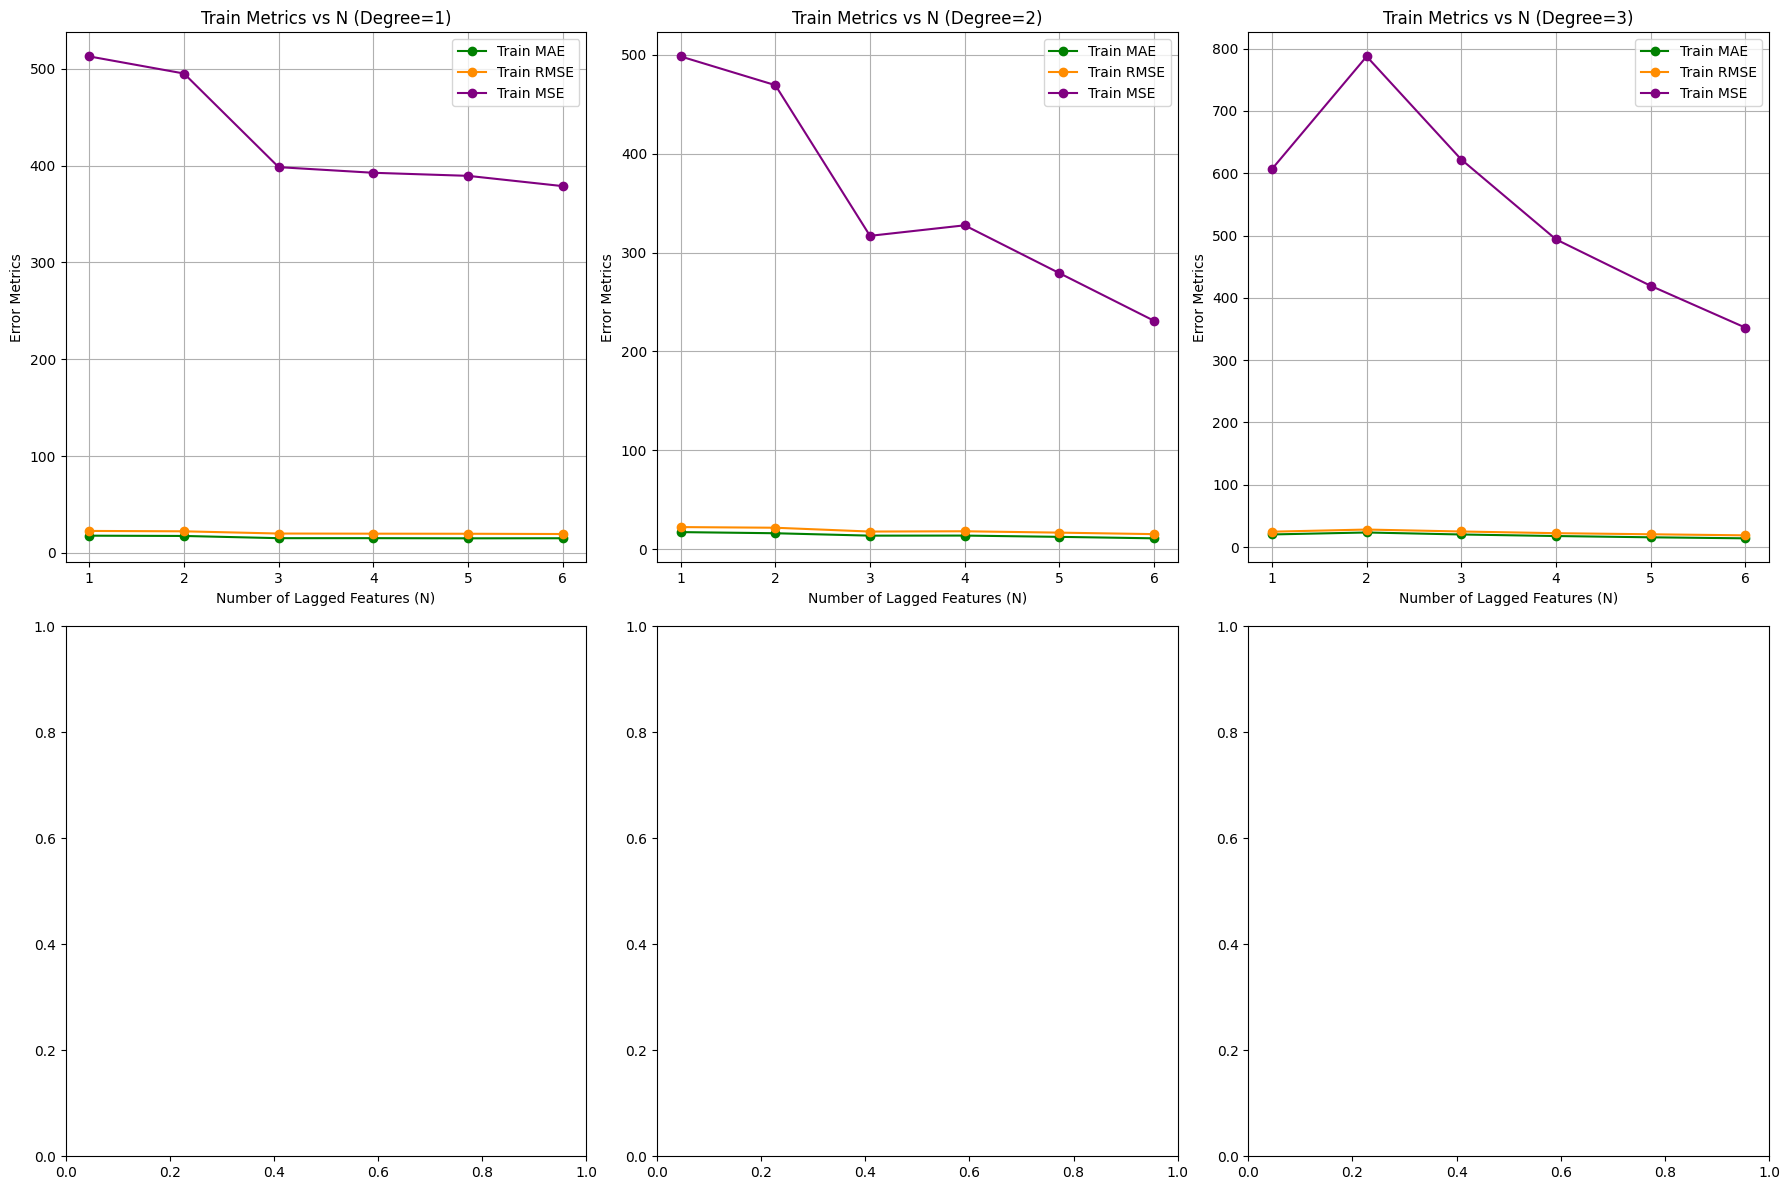

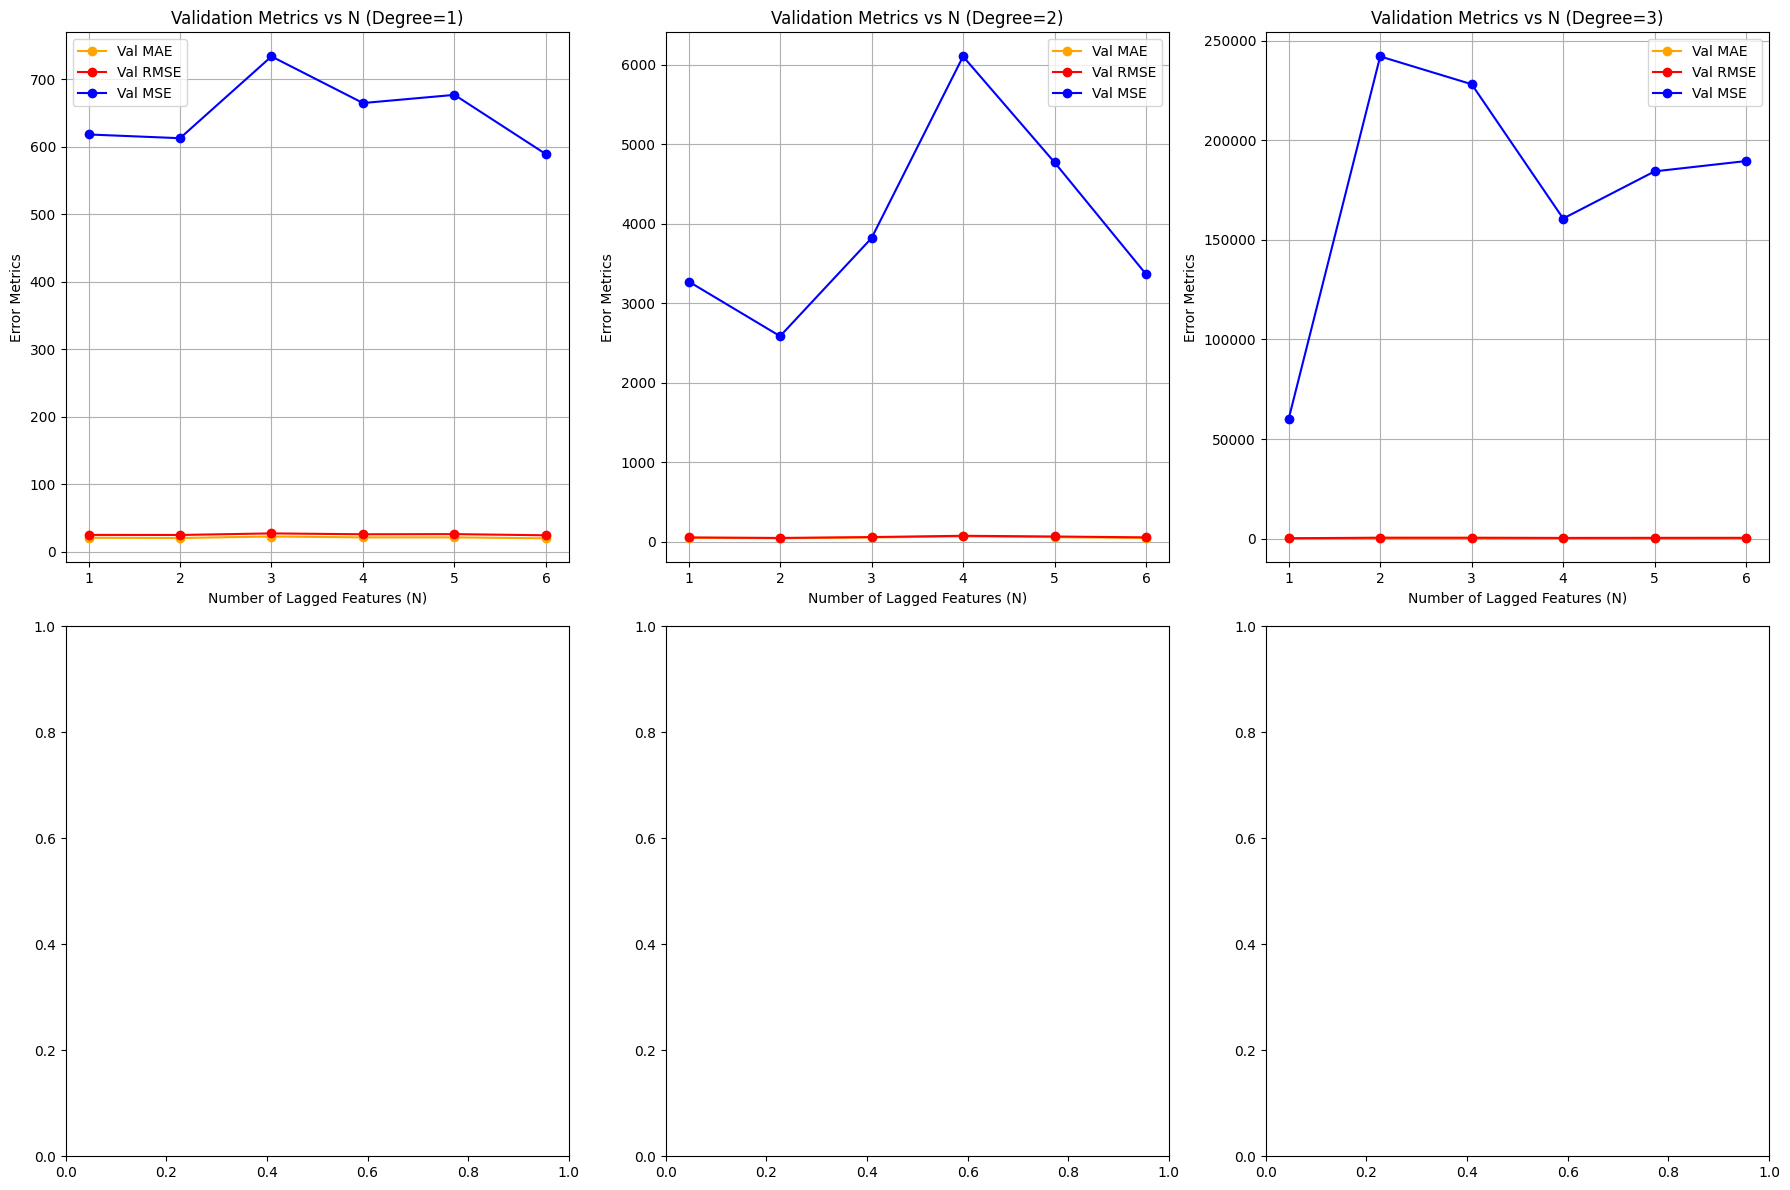

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

TARGET_COL = 'Close'
print("Θα προβλέψουμε τη στήλη:", TARGET_COL)

def polynomial_regression_model_L2(degree, N, data, target_col=TARGET_COL):
    """
    Πολυωνυμική παλινδρόμηση με L2 (Ridge) πάνω σε:
      - close_t-1..close_t-N
      - volume_t-1..volume_t-N

    Χρησιμοποιούμε StandardScaler στα lags και PolynomialFeatures.

    Train:  2018-01-01 <= Date < 2024-01-01
    Val:    Date >= 2024-01-01
    """

    d = data[['Date', 'Close', 'Volume']].copy()
    d = d.sort_values('Date').reset_index(drop=True)

    for i in range(1, N + 1):
        d[f'close_t-{i}']  = d['Close'].shift(i)
        d[f'volume_t-{i}'] = d['Volume'].shift(i)

    d = d.dropna().reset_index(drop=True)

    # Train / Validation split
    train_data = d[(d['Date'] >= '2018-01-01') & (d['Date'] < '2024-01-01')]
    val_data   = d[d['Date'] >= '2024-01-01']

    if len(train_data) == 0 or len(val_data) == 0:
        raise ValueError(f"degree={degree}, N={N}: δεν υπάρχουν αρκετά train/val δείγματα.")

    close_feats  = [f'close_t-{i}'  for i in range(1, N + 1)]
    volume_feats = [f'volume_t-{i}' for i in range(1, N + 1)]
    feature_cols = close_feats + volume_feats

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_val   = val_data[feature_cols].values
    y_val   = val_data[target_col].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly   = poly.transform(X_val_scaled)

    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    base_ridge = Ridge(max_iter=100000)

    grid_search = GridSearchCV(
        base_ridge,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train_poly, y_train)

    alpha = grid_search.best_params_['alpha']

    model = Ridge(alpha=alpha, max_iter=100000)
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_val_pred   = model.predict(X_val_poly)

    train_mse  = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae  = mean_absolute_error(y_train, y_train_pred)

    val_mse  = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae  = mean_absolute_error(y_val, y_val_pred)

    weights = model.coef_
    bias    = model.intercept_

    return (train_mae, train_rmse, train_mse,
            val_mae, val_rmse, val_mse,
            y_train, y_train_pred,
            y_val, y_val_pred,
            val_data['Date'],
            weights, bias,
            alpha, model, scaler, poly)

num_tests  = 6   # N = 1..6
max_degree = 3   # Degree = 1..3

all_results_L2 = []

# 2 x 3 subplots
fig_train, axs_train = plt.subplots(2, 3, figsize=(18, 12))
fig_val,   axs_val   = plt.subplots(2, 3, figsize=(18, 12))

axs_train = axs_train.flatten()
axs_val   = axs_val.flatten()

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        (train_mae, train_rmse, train_mse,
         val_mae, val_rmse, val_mse,
         y_train, y_train_pred,
         y_val, y_val_pred,
         dates, weights, bias,
         alpha, model, scaler, poly) = polynomial_regression_model_L2(degree, N, df, target_col='Close')

        results.append((N, train_mae, train_rmse, train_mse,
                        val_mae, val_rmse, val_mse, alpha))

    results_df = pd.DataFrame(results, columns=[
        'N',
        'Train MAE', 'Train RMSE', 'Train MSE',
        'Val MAE',   'Val RMSE',   'Val MSE',
        'alpha'
    ])
    all_results_L2.append((degree, results_df))

    print(f"\n[L2 Ridge] Metrics για Polynomial Degree {degree}:")
    print(results_df)

    # Training plots
    ax_tr = axs_train[degree - 1]
    ax_tr.plot(results_df['N'], results_df['Train MAE'],  marker='o', linestyle='-', color='green',      label='Train MAE')
    ax_tr.plot(results_df['N'], results_df['Train RMSE'], marker='o', linestyle='-', color='darkorange', label='Train RMSE')
    ax_tr.plot(results_df['N'], results_df['Train MSE'],  marker='o', linestyle='-', color='purple',     label='Train MSE')

    ax_tr.set_title(f'Train Metrics vs N (Degree={degree})')
    ax_tr.set_xlabel('Number of Lagged Features (N)')
    ax_tr.set_ylabel('Error Metrics')
    ax_tr.legend()
    ax_tr.grid(True)

    # Validation plots
    ax_v = axs_val[degree - 1]
    ax_v.plot(results_df['N'], results_df['Val MAE'],  marker='o', linestyle='-', color='orange', label='Val MAE')
    ax_v.plot(results_df['N'], results_df['Val RMSE'], marker='o', linestyle='-', color='red',    label='Val RMSE')
    ax_v.plot(results_df['N'], results_df['Val MSE'],  marker='o', linestyle='-', color='blue',   label='Val MSE')

    ax_v.set_title(f'Validation Metrics vs N (Degree={degree})')
    ax_v.set_xlabel('Number of Lagged Features (N)')
    ax_v.set_ylabel('Error Metrics')
    ax_v.legend()
    ax_v.grid(True)

fig_train.tight_layout()
fig_val.tight_layout()
plt.show()


In [32]:
degree_best_L2 = 1
N_best_L2      = 6

(train_mae, train_rmse, train_mse,
 val_mae, val_rmse, val_mse,
 y_train, y_train_pred,
 y_val, y_val_pred,
 dates, weights, bias,
 alpha_L2, model_L2, scaler_L2, poly_L2) = polynomial_regression_model_L2(degree_best_L2, N_best_L2, df, target_col='Close')

print(f"L2 Ridge – Degree={degree_best_L2}, N={N_best_L2}, alpha={alpha_L2}")
print(f"Train RMSE={train_rmse:.2f}, Val RMSE={val_rmse:.2f}")

target_year  = 2025
target_month = 12

cutoff = pd.Timestamp(target_year, target_month, 1) - MonthEnd(1)
df_until_cutoff = df[df['Date'] <= cutoff].copy()

print("Τελευταία ημερομηνία στο df_until_cutoff:", df_until_cutoff['Date'].max())

next_date, next_pred = predict_next_month_close_poly(df_until_cutoff, model_L2, scaler_L2, poly_L2, N_best_L2)
print(f"[L2 Ridge] Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις {next_date}: {next_pred:.2f} $")


L2 Ridge – Degree=1, N=6, alpha=0.001
Train RMSE=19.47, Val RMSE=24.27
Τελευταία ημερομηνία στο df_until_cutoff: 2025-11-28 00:00:00
[L2 Ridge] Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις 2025-12-31: 546.19 $


In [33]:
degree_best = 1
N_best      = 6

(train_mae, train_rmse, train_mse,
 val_mae, val_rmse, val_mse,
 y_train, y_train_pred,
 y_val, y_val_pred,
 dates, weights, bias,
 alpha, model_L2, scaler_L2, poly_L2) = polynomial_regression_model_L2(degree_best, N_best, df, target_col='Close')

print(f"[L2 Ridge] degree={degree_best}, N={N_best}, alpha={alpha}")
print(f"Train RMSE = {train_rmse:.2f}, Val RMSE = {val_rmse:.2f}")
print(f"Train MAE  = {train_mae:.2f}, Val MAE  = {val_mae:.2f}")

target_year  = 2025
target_month = 1

cutoff = pd.Timestamp(target_year, target_month, 1) - MonthEnd(1)
print("cutoff:", cutoff)

df_until_cutoff = df[df['Date'] <= cutoff].copy()
print("Τελευταία ημερομηνία στο df_until_cutoff:", df_until_cutoff['Date'].max())

pred_date, pred_close = predict_next_month_close_poly(df_until_cutoff,
                                                      model_L2, scaler_L2, poly_L2,
                                                      N_best)

print(f"\nΠροβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις {pred_date}: {pred_close:.2f} $")

mask_jan = (df['Date'].dt.year == target_year) & (df['Date'].dt.month == target_month)
if mask_jan.sum() == 0:
    print(f" Δεν βρέθηκε πραγματική τιμή για Ιανουάριο {target_year} στο df.")
else:
    actual_close = df.loc[mask_jan, 'Close'].iloc[0]
    print(f"Πραγματική τιμή κλεισίματος για Ιανουάριο {target_year}: {actual_close:.2f} $")

    abs_err  = abs(actual_close - pred_close)
    perc_err = abs_err / actual_close * 100

    print(f"Απόλυτο σφάλμα: {abs_err:.2f} $")
    print(f"Ποσοστιαίο σφάλμα: {perc_err:.2f}%")

[L2 Ridge] degree=1, N=6, alpha=0.001
Train RMSE = 19.47, Val RMSE = 24.27
Train MAE  = 15.09, Val MAE  = 19.80
cutoff: 2024-12-31 00:00:00
Τελευταία ημερομηνία στο df_until_cutoff: 2024-12-31 00:00:00

Προβλεπόμενη τιμή κλεισίματος για τον μήνα που λήγει στις 2025-01-31: 505.27 $
Πραγματική τιμή κλεισίματος για Ιανουάριο 2025: 555.43 $
Απόλυτο σφάλμα: 50.16 $
Ποσοστιαίο σφάλμα: 9.03%


**Dimension Regression**

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

def build_lagged_dataset(df, N, target_col='Close'):
    """
    Επιστρέφει:
    X_train, X_val, y_train, y_val, feature_cols, val_dates
    για N lags σε Close & Volume.
    """

    base = df[['Date', 'Close', 'Volume']].copy()
    base = base.sort_values('Date').reset_index(drop=True)

    for i in range(1, N + 1):
        base[f'close_t-{i}']  = base['Close'].shift(i)
        base[f'volume_t-{i}'] = base['Volume'].shift(i)

    base = base.dropna().reset_index(drop=True)

    # Train / Validation split
    train_data = base[(base['Date'] >= '2018-01-01') & (base['Date'] < '2024-01-01')]
    val_data   = base[base['Date'] >= '2024-01-01']

    if len(train_data) == 0 or len(val_data) == 0:
        raise ValueError("Δεν υπάρχουν αρκετά train/val δείγματα. Έλεγξε τις ημερομηνίες.")

    feature_cols = [f'close_t-{i}' for i in range(1, N + 1)] + \
                   [f'volume_t-{i}' for i in range(1, N + 1)]

    X_train = train_data[feature_cols].values
    X_val   = val_data[feature_cols].values
    y_train = train_data[target_col].values
    y_val   = val_data[target_col].values
    val_dates = val_data['Date']

    return X_train, X_val, y_train, y_val, feature_cols, val_dates

    N_best = 5
    X_train, X_val, y_train, y_val, feature_cols, val_dates = build_lagged_dataset(df, N_best)

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc   = scaler.transform(X_val)



In [35]:
from sklearn.preprocessing import StandardScaler

N_best = 5

base = df[['Date', 'Close', 'Volume']].copy()
base = base.sort_values('Date').reset_index(drop=True)

for i in range(1, N_best + 1):
    base[f'close_t-{i}']  = base['Close'].shift(i)
    base[f'volume_t-{i}'] = base['Volume'].shift(i)

base = base.dropna().reset_index(drop=True)

# Train / Validation split
train_data = base[(base['Date'] >= '2018-01-01') & (base['Date'] < '2024-01-01')]
val_data   = base[base['Date'] >= '2024-01-01']

feature_cols = [f'close_t-{i}' for i in range(1, N_best + 1)] + \
               [f'volume_t-{i}' for i in range(1, N_best + 1)]

X_train = train_data[feature_cols].values
y_train = train_data['Close'].values
X_val   = val_data[feature_cols].values
y_val   = val_data['Close'].values

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)


In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca   = pca.transform(X_val_sc)

print("PCA components:", X_train_pca.shape[1])

model_pca = Ridge(alpha=1.0)
model_pca.fit(X_train_pca, y_train)

y_train_pred_pca = model_pca.predict(X_train_pca)
y_val_pred_pca   = model_pca.predict(X_val_pca)

train_mse_pca = mean_squared_error(y_train, y_train_pred_pca)
train_rmse_pca = np.sqrt(train_mse_pca)
train_mae_pca  = mean_absolute_error(y_train, y_train_pred_pca)

val_mse_pca = mean_squared_error(y_val, y_val_pred_pca)
val_rmse_pca = np.sqrt(val_mse_pca)
val_mae_pca  = mean_absolute_error(y_val, y_val_pred_pca)


PCA components: 6


In [37]:
!pip install factor_analyzer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=50e4da3536b5a3bcd438b9f6eef583817ffc26f15020b0871f4c0f2831276c93
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


In [38]:
from factor_analyzer import FactorAnalyzer

n_factors = 2

fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(X_train_sc)

X_train_fa = fa.transform(X_train_sc)
X_val_fa   = fa.transform(X_val_sc)

model_fa = Ridge(alpha=1.0)
model_fa.fit(X_train_fa, y_train)

y_train_pred_fa = model_fa.predict(X_train_fa)
y_val_pred_fa   = model_fa.predict(X_val_fa)

train_mse_fa = mean_squared_error(y_train, y_train_pred_fa)
train_rmse_fa = np.sqrt(train_mse_fa)
train_mae_fa  = mean_absolute_error(y_train, y_train_pred_fa)

val_mse_fa = mean_squared_error(y_val, y_val_pred_fa)
val_rmse_fa = np.sqrt(val_mse_fa)
val_mae_fa  = mean_absolute_error(y_val, y_val_pred_fa)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = Ridge(alpha=1.0)

n_select = 4

sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=n_select,
    direction='forward',
    cv=None
)

sfs.fit(X_train_sc, y_train)

selected_mask = sfs.get_support()
selected_features = [f for f, m in zip(feature_cols, selected_mask) if m]
print("Wrapper – επιλεγμένα features:", selected_features)

X_train_wrap = X_train_sc[:, selected_mask]
X_val_wrap   = X_val_sc[:, selected_mask]

model_wrap = Ridge(alpha=1.0)
model_wrap.fit(X_train_wrap, y_train)

y_train_pred_wrap = model_wrap.predict(X_train_wrap)
y_val_pred_wrap   = model_wrap.predict(X_val_wrap)

train_mse_wrap = mean_squared_error(y_train, y_train_pred_wrap)
train_rmse_wrap = np.sqrt(train_mse_wrap)
train_mae_wrap  = mean_absolute_error(y_train, y_train_pred_wrap)

val_mse_wrap = mean_squared_error(y_val, y_val_pred_wrap)
val_rmse_wrap = np.sqrt(val_mse_wrap)
val_mae_wrap  = mean_absolute_error(y_val, y_val_pred_wrap)


Wrapper – επιλεγμένα features: ['close_t-1', 'close_t-2', 'close_t-3', 'close_t-4']


Feature cols: ['close_t-1', 'close_t-2', 'close_t-3', 'close_t-4', 'close_t-5', 'volume_t-1', 'volume_t-2', 'volume_t-3', 'volume_t-4', 'volume_t-5']
X_train shape: (72, 10) X_val shape: (24, 10)

 BASELINE
Train MAE:  15.13
Train RMSE: 20.02
Val   MAE:  22.88
Val   RMSE: 27.98

 PCA 
PCA components: 6, explained variance: 98.11%
PCA – Train MAE:  16.87, RMSE: 22.47
PCA – Val   MAE:  29.46, RMSE: 36.02

 Factor Analysis (n_factors=2)
FA – Train MAE:  17.97, RMSE: 23.65
FA – Val   MAE:  31.80, RMSE: 38.51

 WRAPPER (Sequential Feature Selector)
Επιλεγμένα features: ['close_t-1', 'close_t-2', 'close_t-3', 'close_t-4']
Wrapper – Train MAE:  15.75, RMSE: 20.33
Wrapper – Val   MAE:  21.28, RMSE: 25.82


 Συνολικός πίνακας αποτελεσμάτων 
            Model  Dimensionality  Train_MAE  Train_RMSE    Val_MAE  \
0        Baseline              10  15.133958   20.015323  22.878518   
1             PCA               6  16.869969   22.471012  29.457560   
2  FactorAnalysis               2  17.965430 

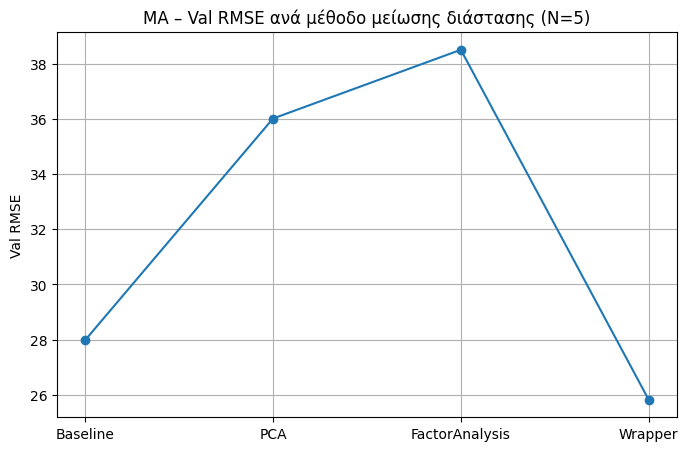

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.feature_selection import SequentialFeatureSelector

def build_lagged_dataset(df, N, target_col='Close'):
    """
    Φτιάχνει dataset με:
      - lags για Close:  close_t-1..close_t-N
      - lags για Volume: volume_t-1..volume_t-N
    και κάνει split σε train/validation.

    Επιστρέφει:
      X_train, X_val, y_train, y_val, feature_cols, val_dates
    """

    base = df[['Date', 'Close', 'Volume']].copy()
    base = base.sort_values('Date').reset_index(drop=True)

    # N lags
    for i in range(1, N + 1):
        base[f'close_t-{i}']  = base['Close'].shift(i)
        base[f'volume_t-{i}'] = base['Volume'].shift(i)

    base = base.dropna().reset_index(drop=True)

    # Train: 2018–2023, Validation: 2024+
    train_mask = (base['Date'] >= '2018-01-01') & (base['Date'] < '2024-01-01')
    val_mask   = (base['Date'] >= '2024-01-01')

    train_data = base[train_mask]
    val_data   = base[val_mask]

    if len(train_data) == 0 or len(val_data) == 0:
        raise ValueError("Δεν υπάρχουν αρκετά train/validation δείγματα. Έλεγξε τις ημερομηνίες ή το N.")

    feature_cols = [f'close_t-{i}'  for i in range(1, N + 1)] + \
                   [f'volume_t-{i}' for i in range(1, N + 1)]

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_val   = val_data[feature_cols].values
    y_val   = val_data[target_col].values
    val_dates = val_data['Date'].values

    return X_train, X_val, y_train, y_val, feature_cols, val_dates


def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    return mae, rmse, mse


N_best = 5

X_train, X_val, y_train, y_val, feature_cols, val_dates = build_lagged_dataset(df, N_best)

print("Feature cols:", feature_cols)
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)

baseline_model = Ridge(alpha=1.0)
baseline_model.fit(X_train_sc, y_train)

y_train_pred_base = baseline_model.predict(X_train_sc)
y_val_pred_base   = baseline_model.predict(X_val_sc)

train_mae_base, train_rmse_base, train_mse_base = compute_metrics(y_train, y_train_pred_base)
val_mae_base,   val_rmse_base,   val_mse_base   = compute_metrics(y_val,   y_val_pred_base)

print("\n BASELINE")
print(f"Train MAE:  {train_mae_base:.2f}")
print(f"Train RMSE: {train_rmse_base:.2f}")
print(f"Val   MAE:  {val_mae_base:.2f}")
print(f"Val   RMSE: {val_rmse_base:.2f}")

# PCA/Ridge

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca   = pca.transform(X_val_sc)

n_pca = X_train_pca.shape[1]
expl_var = pca.explained_variance_ratio_.sum() * 100

print(f"\n PCA ")
print(f"PCA components: {n_pca}, explained variance: {expl_var:.2f}%")

model_pca = Ridge(alpha=1.0)
model_pca.fit(X_train_pca, y_train)

y_train_pred_pca = model_pca.predict(X_train_pca)
y_val_pred_pca   = model_pca.predict(X_val_pca)

train_mae_pca, train_rmse_pca, train_mse_pca = compute_metrics(y_train, y_train_pred_pca)
val_mae_pca,   val_rmse_pca,   val_mse_pca   = compute_metrics(y_val,   y_val_pred_pca)

print(f"PCA – Train MAE:  {train_mae_pca:.2f}, RMSE: {train_rmse_pca:.2f}")
print(f"PCA – Val   MAE:  {val_mae_pca:.2f}, RMSE: {val_rmse_pca:.2f}")

# Factor Analysis/Ridge

n_factors = 2

fa = FactorAnalysis(n_components=n_factors, random_state=0)
X_train_fa = fa.fit_transform(X_train_sc)
X_val_fa   = fa.transform(X_val_sc)

model_fa = Ridge(alpha=1.0)
model_fa.fit(X_train_fa, y_train)

y_train_pred_fa = model_fa.predict(X_train_fa)
y_val_pred_fa   = model_fa.predict(X_val_fa)

train_mae_fa, train_rmse_fa, train_mse_fa = compute_metrics(y_train, y_train_pred_fa)
val_mae_fa,   val_rmse_fa,   val_mse_fa   = compute_metrics(y_val,   y_val_pred_fa)

print(f"\n Factor Analysis (n_factors={n_factors})")
print(f"FA – Train MAE:  {train_mae_fa:.2f}, RMSE: {train_rmse_fa:.2f}")
print(f"FA – Val   MAE:  {val_mae_fa:.2f}, RMSE: {val_rmse_fa:.2f}")

# Wrapper method (Sequential Feature Selector)/Ridge

n_select = 4

base_model = Ridge(alpha=1.0)
sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=n_select,
    direction='forward',
    cv=None
)
sfs.fit(X_train_sc, y_train)

selected_mask = sfs.get_support()
selected_features = [f for f, m in zip(feature_cols, selected_mask) if m]

print("\n WRAPPER (Sequential Feature Selector)")
print("Επιλεγμένα features:", selected_features)

X_train_wrap = X_train_sc[:, selected_mask]
X_val_wrap   = X_val_sc[:, selected_mask]

model_wrap = Ridge(alpha=1.0)
model_wrap.fit(X_train_wrap, y_train)

y_train_pred_wrap = model_wrap.predict(X_train_wrap)
y_val_pred_wrap   = model_wrap.predict(X_val_wrap)

train_mae_wrap, train_rmse_wrap, train_mse_wrap = compute_metrics(y_train, y_train_pred_wrap)
val_mae_wrap,   val_rmse_wrap,   val_mse_wrap   = compute_metrics(y_val,   y_val_pred_wrap)

print(f"Wrapper – Train MAE:  {train_mae_wrap:.2f}, RMSE: {train_rmse_wrap:.2f}")
print(f"Wrapper – Val   MAE:  {val_mae_wrap:.2f}, RMSE: {val_rmse_wrap:.2f}")


results_dimred = pd.DataFrame({
    'Model': ['Baseline', 'PCA', 'FactorAnalysis', 'Wrapper'],
    'Dimensionality': [
        X_train_sc.shape[1],  # 2N
        n_pca,
        n_factors,
        n_select
    ],
    'Train_MAE':  [train_mae_base,  train_mae_pca,  train_mae_fa,  train_mae_wrap],
    'Train_RMSE': [train_rmse_base, train_rmse_pca, train_rmse_fa, train_rmse_wrap],
    'Val_MAE':    [val_mae_base,    val_mae_pca,    val_mae_fa,    val_mae_wrap],
    'Val_RMSE':   [val_rmse_base,   val_rmse_pca,   val_rmse_fa,   val_rmse_wrap],
    'Val_MSE':    [val_mse_base,    val_mse_pca,    val_mse_fa,    val_mse_wrap],
})

print("\n\n Συνολικός πίνακας αποτελεσμάτων ")
print(results_dimred)

plt.figure(figsize=(8, 5))
plt.plot(results_dimred['Model'], results_dimred['Val_RMSE'], marker='o')
plt.title(f'MA – Val RMSE ανά μέθοδο μείωσης διάστασης (N={N_best})')
plt.ylabel('Val RMSE')
plt.grid(True)
plt.show()